In [1]:
# -*- coding: utf-8 -*-
"""
Created on Sun May 28 11:38:35 2023

The MPC controller takes in the filtered state 'x' after converting from ECI to RTN
"""

import math
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

from math import sqrt, sin, asin, cos, tan, atan2, pi
from numpy.linalg import norm, inv, pinv
from scipy.linalg import expm, sinm, cosm

from source import spacecraft
from aa273_control import *


In [10]:

##############################################################################
##############################################################################
###                                                                        ###
###               SETTING UP OF THE GPS CONSTELLATION BELOW                ###
###                                                                        ###
##############################################################################
##############################################################################

#region
# GPS Almanac Week 204: All available PRN IDs
prns = [ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
         7, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31 ]

# GPS Almanac Week 204: Semi-Major Axis [km]
GPS_SMAX = 26599.800

# GPS Almanac Week 204: Eccentricity [unitless]
GPS_ECCN = 0.000001

# GPS Almanac Week 204: Inclination [deg]
GPS_INCL = 55.0
        
# GPS Almanac Week 204: Right Angle of the Ascending Node [deg]
GPS_RAAN = [-143.881352, -149.446614,  -84.778512,  -22.818990,  -87.385619,
            -144.357305,   35.349176,  153.734801,  -26.028092,  -84.931462,
            -141.883192,   99.225855,  -16.924009,   97.083800,  -32.683446,
             100.277002,  158.759866, -143.755546,  161.314101,  -94.320245,
            -149.686511,  -86.467123,   30.236113,   94.562051,   91.458499,
             155.031466,   33.155708,  159.555151,   35.770562,   36.473751,
             -25.294003]

# GPS Almanac Week 204: Argument of Periapsis [deg]
GPS_ARGP = [  53.765545,  -75.631986,   57.743969, -173.043165,   64.681857,
             -46.573319, -127.231250,   13.148360,  112.699728, -139.444742,
            -154.121597,   76.981738,   53.130934, -176.496584,   67.669709,
              44.494200,  -81.162593, -178.499508,  128.866153, -166.197417,
             -45.969586, -177.202756,   50.789967,   59.425199,   26.153212,
              40.480607,   96.978207,  136.728158, -151.319311,   29.645619,
            -128.456075]

# GPS Almanac Week 204: Mean Anomaly [deg]
GPS_ANOM = [ -86.960177, -144.505126, -152.714424,   13.494215,   61.374757,
             -74.233353, -120.546970,   39.999955,   59.759746,  152.572997,
              -2.914681, -167.377052,   14.453008, -163.841686,  -15.388842,
              87.047746,   37.617981,  -80.040336,  160.861859,  -37.675960,
              36.690388, -139.207914,  -70.966229, -173.403954,  142.599792,
              40.680892,  147.604237,   43.801439, -129.846039, -157.112496,
              78.628936]

# Initialize both chief and deputy.
sc1_elements = [6918.14, 0.00001, 97.59760, 0.000000, -109.33800,   0.00827]
sc2_elements = [6918.14, 0.00722, 97.5976, 134.94389, -108.5025, -134.71026] 
sc1 = spacecraft.Spacecraft( elements = sc1_elements )
sc2 = spacecraft.Spacecraft( elements = sc2_elements )

# Set the chief of the spacecraft. Enable maneuvers for SC2.
sc2.chief = sc1 # ROEs and RTN states computed w.r.t. SC1


# Initialize GPS satellite osculating Keplerian elements
gps01oe = [GPS_SMAX, GPS_ECCN, GPS_INCL, GPS_RAAN[ 0], GPS_ARGP[ 0], GPS_ANOM[ 0]]
gps02oe = [GPS_SMAX, GPS_ECCN, GPS_INCL, GPS_RAAN[ 1], GPS_ARGP[ 1], GPS_ANOM[ 1]]
gps03oe = [GPS_SMAX, GPS_ECCN, GPS_INCL, GPS_RAAN[ 2], GPS_ARGP[ 2], GPS_ANOM[ 2]]
gps04oe = [GPS_SMAX, GPS_ECCN, GPS_INCL, GPS_RAAN[ 3], GPS_ARGP[ 3], GPS_ANOM[ 3]]
gps05oe = [GPS_SMAX, GPS_ECCN, GPS_INCL, GPS_RAAN[ 4], GPS_ARGP[ 4], GPS_ANOM[ 4]]
gps06oe = [GPS_SMAX, GPS_ECCN, GPS_INCL, GPS_RAAN[ 5], GPS_ARGP[ 5], GPS_ANOM[ 5]]
gps07oe = [GPS_SMAX, GPS_ECCN, GPS_INCL, GPS_RAAN[ 6], GPS_ARGP[ 6], GPS_ANOM[ 6]]
gps08oe = [GPS_SMAX, GPS_ECCN, GPS_INCL, GPS_RAAN[ 7], GPS_ARGP[ 7], GPS_ANOM[ 7]]
gps09oe = [GPS_SMAX, GPS_ECCN, GPS_INCL, GPS_RAAN[ 8], GPS_ARGP[ 8], GPS_ANOM[ 8]]
gps10oe = [GPS_SMAX, GPS_ECCN, GPS_INCL, GPS_RAAN[ 9], GPS_ARGP[ 9], GPS_ANOM[ 9]]
gps11oe = [GPS_SMAX, GPS_ECCN, GPS_INCL, GPS_RAAN[10], GPS_ARGP[10], GPS_ANOM[10]]
gps12oe = [GPS_SMAX, GPS_ECCN, GPS_INCL, GPS_RAAN[11], GPS_ARGP[11], GPS_ANOM[11]]
gps13oe = [GPS_SMAX, GPS_ECCN, GPS_INCL, GPS_RAAN[12], GPS_ARGP[12], GPS_ANOM[12]]
gps14oe = [GPS_SMAX, GPS_ECCN, GPS_INCL, GPS_RAAN[13], GPS_ARGP[13], GPS_ANOM[13]]
gps15oe = [GPS_SMAX, GPS_ECCN, GPS_INCL, GPS_RAAN[14], GPS_ARGP[14], GPS_ANOM[14]]
gps16oe = [GPS_SMAX, GPS_ECCN, GPS_INCL, GPS_RAAN[15], GPS_ARGP[15], GPS_ANOM[15]]
gps17oe = [GPS_SMAX, GPS_ECCN, GPS_INCL, GPS_RAAN[16], GPS_ARGP[16], GPS_ANOM[16]]
gps18oe = [GPS_SMAX, GPS_ECCN, GPS_INCL, GPS_RAAN[17], GPS_ARGP[17], GPS_ANOM[17]]
gps19oe = [GPS_SMAX, GPS_ECCN, GPS_INCL, GPS_RAAN[18], GPS_ARGP[18], GPS_ANOM[18]]
gps20oe = [GPS_SMAX, GPS_ECCN, GPS_INCL, GPS_RAAN[19], GPS_ARGP[19], GPS_ANOM[19]]
gps21oe = [GPS_SMAX, GPS_ECCN, GPS_INCL, GPS_RAAN[20], GPS_ARGP[20], GPS_ANOM[20]]
gps22oe = [GPS_SMAX, GPS_ECCN, GPS_INCL, GPS_RAAN[21], GPS_ARGP[21], GPS_ANOM[21]]
gps23oe = [GPS_SMAX, GPS_ECCN, GPS_INCL, GPS_RAAN[22], GPS_ARGP[22], GPS_ANOM[22]]
gps24oe = [GPS_SMAX, GPS_ECCN, GPS_INCL, GPS_RAAN[23], GPS_ARGP[23], GPS_ANOM[23]]
gps25oe = [GPS_SMAX, GPS_ECCN, GPS_INCL, GPS_RAAN[24], GPS_ARGP[24], GPS_ANOM[24]]
gps26oe = [GPS_SMAX, GPS_ECCN, GPS_INCL, GPS_RAAN[25], GPS_ARGP[25], GPS_ANOM[25]]
gps27oe = [GPS_SMAX, GPS_ECCN, GPS_INCL, GPS_RAAN[26], GPS_ARGP[26], GPS_ANOM[26]]
gps28oe = [GPS_SMAX, GPS_ECCN, GPS_INCL, GPS_RAAN[27], GPS_ARGP[27], GPS_ANOM[27]]
gps29oe = [GPS_SMAX, GPS_ECCN, GPS_INCL, GPS_RAAN[28], GPS_ARGP[28], GPS_ANOM[28]]
gps30oe = [GPS_SMAX, GPS_ECCN, GPS_INCL, GPS_RAAN[29], GPS_ARGP[29], GPS_ANOM[29]]
gps31oe = [GPS_SMAX, GPS_ECCN, GPS_INCL, GPS_RAAN[30], GPS_ARGP[30], GPS_ANOM[30]]

# Generate all GPS satellites at initial conditions.
gps01 = spacecraft.Spacecraft( elements = gps01oe )
gps02 = spacecraft.Spacecraft( elements = gps02oe )
gps03 = spacecraft.Spacecraft( elements = gps03oe )
gps04 = spacecraft.Spacecraft( elements = gps04oe )
gps05 = spacecraft.Spacecraft( elements = gps05oe )
gps06 = spacecraft.Spacecraft( elements = gps06oe )
gps07 = spacecraft.Spacecraft( elements = gps07oe )
gps08 = spacecraft.Spacecraft( elements = gps08oe )
gps09 = spacecraft.Spacecraft( elements = gps09oe )
gps10 = spacecraft.Spacecraft( elements = gps10oe )
gps11 = spacecraft.Spacecraft( elements = gps11oe )
gps12 = spacecraft.Spacecraft( elements = gps12oe )
gps13 = spacecraft.Spacecraft( elements = gps13oe )
gps14 = spacecraft.Spacecraft( elements = gps14oe )
gps15 = spacecraft.Spacecraft( elements = gps15oe )
gps16 = spacecraft.Spacecraft( elements = gps16oe )
gps17 = spacecraft.Spacecraft( elements = gps17oe )
gps18 = spacecraft.Spacecraft( elements = gps18oe )
gps19 = spacecraft.Spacecraft( elements = gps19oe )
gps20 = spacecraft.Spacecraft( elements = gps20oe )
gps21 = spacecraft.Spacecraft( elements = gps21oe )
gps22 = spacecraft.Spacecraft( elements = gps22oe )
gps23 = spacecraft.Spacecraft( elements = gps23oe )
gps24 = spacecraft.Spacecraft( elements = gps24oe )
gps25 = spacecraft.Spacecraft( elements = gps25oe )
gps26 = spacecraft.Spacecraft( elements = gps26oe )
gps27 = spacecraft.Spacecraft( elements = gps27oe )
gps28 = spacecraft.Spacecraft( elements = gps28oe )
gps29 = spacecraft.Spacecraft( elements = gps29oe )
gps30 = spacecraft.Spacecraft( elements = gps30oe )
gps31 = spacecraft.Spacecraft( elements = gps31oe )

# endregion

# Group all GPS satellites together into a constellation.
gps_constellation = [ gps01, gps02, gps03, gps04, gps05, gps06, gps07, gps08,
                      gps09, gps10, gps11, gps12, gps13, gps14, gps15, gps16,
                      gps17, gps18, gps19, gps21, gps22, gps23, gps24, gps25,
                      gps25, gps26, gps27, gps28, gps29, gps30, gps31 ]
# end region
##############################################################################
##############################################################################
###                                                                        ###
###              AUXILIARY FUNCTIONS FOR GPS CONSTELLATION                 ###
###                                                                        ###
##############################################################################
##############################################################################
def get_hill_frame(r, v):
    h = np.cross(r, v)  # Angular momentum vector
    r_hat = r / np.linalg.norm(r)  # Local X-axis (R)
    h_hat = h / np.linalg.norm(h)  # Local Z-axis (N)
    y_hat = np.cross(h_hat, r_hat)  # Local Y-axis (T)
    return np.array([r_hat, y_hat, h_hat])

def rv_rtn_to_eci(rv_c_eci, r_rtn, v_rtn):
    r = rv_c_eci[0:3]
    v = rv_c_eci[3:6]
    matrix_eci2rtn = get_hill_frame(r, v)
    nuDot = norm(np.cross(r, v)) / (norm(r)**2)
    omega = np.array([0.0, 0.0, nuDot])
    rho = np.transpose(matrix_eci2rtn) @ r_rtn
    rhoDot = np.transpose(matrix_eci2rtn) @ (v_rtn + np.cross(omega, r_rtn))
    rv_cd_eci = np.zeros(6)
    rv_cd_eci[0:3] = rho
    rv_cd_eci[3:6] = rhoDot
    return rv_cd_eci # This returns the RELATIVE state in ECI

def rv_eci_to_rtn(rv_c_eci, rv_cd_eci):
    r = rv_c_eci[0:3]
    v = rv_c_eci[3:6]
    rho = rv_cd_eci[0:3]
    rhoDot = rv_cd_eci[3:6]
    nuDot = norm(np.cross(r, v)) / (norm(r)**2)  # true anomaly derivative
    omega = np.array([0.0, 0.0, nuDot])
    matrix_eci2rtn = get_hill_frame(r, v)
    r_rtn = matrix_eci2rtn @ rho
    v_rtn = matrix_eci2rtn @ rhoDot - np.cross(omega, r_rtn)
    
    return r_rtn, v_rtn

# Function to convert ECEF (xyz) to Geodetic (lat-lon-alt) coordinates
def ecef_to_geodetic(pos):
    if len(pos) != 3:
        raise ValueError('ECEF to Geodetic: Position vector must be length 3!')
        return np.array([0,0,0])
    earthRad = 6378136.300       # Radius of Earth (WGS84)
    earthEcc = 0.081819190842622 # Earth eccentricity (WGS84)
    x, y, z, r = pos[0], pos[1], pos[2], norm(pos)
    lon = atan2(y,x)
    lat0 = asin(z/r) 
    lat = lat0 # Initial guess
    n, nMax = 0, 3 # Number of iterations
    error, tol = 1, 1E-12
    rxy = norm([x,y])
    while (error > tol) and (n < nMax):
        lat0 = lat
        N = earthRad / sqrt(1 - (earthEcc * sin(lat0))**2)
        lat = atan2(z + (N * earthEcc * earthEcc) * sin(lat0), rxy)
        error = abs(lat - lat0)
        n += 1
    alt = (rxy - cos(lat)) - N
    geodetic = np.array([lat, lon, alt])
    return geodetic

# Computes the azimuth, elevation, and range from positions 0 to 1
def compute_aer(pos0, pos1):
    lla = ecef_to_geodetic(pos0)
    lat, lon = lla[0], lla[1]
    so = sin(lon)
    co = cos(lon)
    sa = sin(lat)
    ca = cos(lat)
    rotation = np.array(
        [[-so,            co, 0.0],
         [-sa * co, -sa * so, ca ],
         [ ca * co,  ca * so, sa ]])
    enu = rotation @ (pos1 - pos0)
    azim = atan2(enu[0], enu[1]);
    elev = atan2(enu[2], norm(enu[0:2]));
    rnge = norm(enu);
    enu = np.array([azim, elev, rnge]);
    return enu

##############################################################################
##############################################################################
###                                                                        ###
###               FUNCTIONS TO COMPUTE JACOBIANS FOR FILTER                ###
###                                                                        ###
##############################################################################
##############################################################################

# Computes the state transition matrix for absolute orbital motion
# It requires rough knowledge on the norm of the S/C pose

# def compute_A(R):
#     # First, get the continuous state space plant matrix
#     GM = 398600.4418  # G * Earth Mass (km**3/s**2)
#     F = -GM/(R**3) # Two-body force
#     A11 = np.zeros((3,3))
#     A12 = np.eye(3)
#     A21 = F * np.eye(3)
#     A22 = np.zeros((3,3))
#     A1 = np.concatenate((A11, A12), axis=1)
#     A2 = np.concatenate((A21, A22), axis=1)
#     A = np.concatenate((A1, A2), axis=0)
#     return expm(A)

def compute_A(dt, R):
    GM = 398600.4418
    F = -(GM / (R**3)) * dt
    A = np.array([
        [1, 0, 0, dt, 0, 0],
        [0, 1, 0, 0, dt, 0],
        [0, 0, 1, 0, 0, dt],
        [F, 0, 0, 1, 0, 0],
        [0, F, 0, 0, 1, 0],
        [0, 0, F, 0, 0, 1]])
    return A

# Computes the Jacobian of a single scalar range measurement
def compute_C(rho, pos_rcv, pos_gps):
    dx = pos_rcv[0] - pos_gps[0]
    dy = pos_rcv[1] - pos_gps[1]
    dz = pos_rcv[2] - pos_gps[2]
    C = np.array([ dx/rho, dy/rho, dz/rho, 0, 0, 0 ])
    return C

# Computes the Jacobian of a single scalar Doppler measurement
def compute_Cdot(pos_rcv, pos_gps, vel_rcv, vel_gps):
    dpos = pos_gps - pos_rcv
    dvel = vel_gps - vel_rcv
    rho = norm(pos_gps - pos_rcv)
    prx = -1 * dvel[0] / rho
    pry = -1 * dvel[1] / rho
    prz = -1 * dvel[2] / rho
    pvx = -1 * dpos[0] / rho
    pvy = -1 * dpos[1] / rho
    pvz = -1 * dpos[2] / rho
    Cdot = np.array([ prx, pry, prz, pvx, pvy, pvz ])
    return Cdot

def compute_A_rel(x, dt):
    GM = 398600.4418
    a = np.linalg.norm(x[0:3]) #approximation for circular orbit
    n = np.sqrt(GM/a**3)
    c = np.cos(dt*n)
    s = np.sin(dt*n)
    A = np.array([
        [4-3*c, 0, 0, s/n, 2/n*(1-c), 0],
        [-6*n*dt + 6*s, 1, 0, 2/n*(c-1), 4*s/n-3*dt, 0],
        [0, 0, c, 0, 0, s/n],
        [3*n*s, 0, 0, c, 2*s, 0],
        [6*n*(c-1), 0, 0, -2*s, -3+4*c, 0],
        [0, 0, -n*s, 0, 0, c]])
    return A
    
def compute_C_bearing(x):
    r,t,n = x[6:9]
    rt_norm = np.sqrt(r**2+t**2);
    rtn_norm = np.sqrt(r**2+t**2+n**2);
    #C = np.array([
     #   [r/rtn_norm, t/rtn_norm, n/rtn_norm, 0, 0, 0],
       # [-r*t/(np.abs(r)*rt_norm**2), np.abs(r)/rt_norm**2, 0, 0, 0, 0],
        #[-r*n/(rt_norm*rtn_norm**2), -t*n/(rt_norm*rtn_norm**2),  rt_norm/rtn_norm**2, 0, 0, 0]
    #])
    C = np.array([
        [r/rtn_norm, t/rtn_norm, n/rtn_norm, 0, 0, 0],
        [t/(rt_norm**2), -r/rt_norm**2, 0, 0, 0, 0],
        [-r*n/(rt_norm*rtn_norm**2), -t*n/(rt_norm*rtn_norm**2),  rt_norm/rtn_norm**2, 0, 0, 0]
    ])
    #C = np.array([
     #   [1, 0, 0, 0, 0, 0],
      #  [0, 1, 0, 0, 0, 0],
       # [0, 0, 1, 0, 0, 0]]) 
    return C

def angle_measure(x,R):
    r,t,n = x[6:9]
    #theta = np.arcsin(r/np.sqrt(r**2+t**2))
    #phi = np.arcsin(n/np.sqrt(r**2+t**2+n**2))
    theta = np.arctan2(r,t)
    phi = np.arctan2(n,np.sqrt(r**2+t**2))
    d = np.linalg.norm(x[6:9])
    y = np.array([d,theta,phi])
    y = y + np.random.multivariate_normal(np.zeros(3), R)
    
    #y = np.array([theta,phi])
    #y = y + np.random.multivariate_normal(np.zeros(2), R)
    
    #y = np.array([d])
    #y = y + np.random.multivariate_normal(np.zeros(1), R)    
        
    #y = np.array([r,t,n])
    return y

def update_state(x,u,dt):
    rv_chaser_eci = x[0:6]
    r_target_rtn = x[6:9]
    v_target_rtn = x[9:]
    rv_target_eci = rv_chaser_eci + rv_rtn_to_eci(rv_chaser_eci, r_target_rtn, v_target_rtn)
    
    sc_target_dummy = spacecraft.Spacecraft(states = rv_target_eci)
    sc_chaser_dummy = spacecraft.Spacecraft(states = rv_chaser_eci)
    sc_chaser_dummy.set_force_frame('ECI')
    
    sc_chaser_dummy.set_thruster_acceleration = u
    sc_chaser_dummy.propagate_perturbed(dt, dt)
    sc_target_dummy.propagate_orbit(dt)
    
    rv_chaser_eci = np.array([sc_chaser_dummy.px, sc_chaser_dummy.py, sc_chaser_dummy.pz, sc_chaser_dummy.vx, sc_chaser_dummy.vy, sc_chaser_dummy.vz])
    rv_target_eci = np.array([sc_target_dummy.px, sc_target_dummy.py, sc_target_dummy.pz, sc_target_dummy.vx, sc_target_dummy.vy, sc_target_dummy.vz])
    rtn_pos, rtn_vel = rv_eci_to_rtn(rv_chaser_eci, rv_target_eci - rv_chaser_eci)
    x = np.array([sc_chaser_dummy.px, sc_chaser_dummy.py, sc_chaser_dummy.pz, sc_chaser_dummy.vx, sc_chaser_dummy.vy, sc_chaser_dummy.vz, rtn_pos[0], rtn_pos[1], rtn_pos[2], rtn_vel[0], rtn_vel[1], rtn_vel[2]])  
    
    return x

In [11]:
##############################################################################
##############################################################################
###                                                                        ###
###               SETTING UP OF THE ACTUAL FLIGHT SIMULATION               ###
###                                                                        ###
##############################################################################
##############################################################################

#sc1_elements = [6918.14, 0.00012, 97.59760, 0.000000, -109.33800,   0.00827]
sc1_elements = [6918.14, 0.0011, 97.59760, 45, -109.33800,   0.01001]
sc1 = spacecraft.Spacecraft( elements = sc1_elements )

#target_sc_elements = [6918.14, 0.0001, 97.6, 0.01, -109.3, 0.015]
target_sc_elements = [6918.14, 0.001, 97.6, 45.002, -109.338, 0.01]
sc_target = spacecraft.Spacecraft( elements = target_sc_elements )

# Setup the simulation parameters
dt = 10;
duration = 10000;
samples = math.floor(duration / dt);

# Setup the initial state and initial (prior) distribution
rv_target_eci = np.array([sc_target.px, sc_target.py, sc_target.pz, sc_target.vx, sc_target.vy, sc_target.vz])
rv_sc1_eci = np.array([sc1.px, sc1.py, sc1.pz, sc1.vx, sc1.vy, sc1.vz])
rtn_pos, rtn_vel = rv_eci_to_rtn(rv_sc1_eci, rv_target_eci - rv_sc1_eci)
#eci2rtn = sc1.get_hill_frame()
#rtn_pos = eci2rtn @ np.array([sc_target.px-sc1.px, sc_target.py-sc1.py, sc_target.pz-sc1.pz])
#rtn_vel = eci2rtn @ np.array([sc_target.vx-sc1.vx, sc_target.vy-sc1.vy, sc_target.vz-sc1.vz])
x = np.array([ sc1.px, sc1.py, sc1.pz, sc1.vx, sc1.vy, sc1.vz, rtn_pos[0], rtn_pos[1], rtn_pos[2], rtn_vel[0], rtn_vel[1], rtn_vel[2]])
P = 1000 * np.eye(12) # Filter prior distribution covariance

# Corrupt the initial state estimate 0.01% or about 1km
x_prop_prev = x
#x = x + np.random.multivariate_normal(np.zeros(12), np.diag([.0001, .0001, .0001, .0001, .000001, .000001, .0000, .0000, .0000, .0000001, .0000001, .0000001]))

# Setup the process and measurement noise
Q = np.diag([dt/100, dt/100, dt/100, dt/100000, dt/100000, dt/100000, dt/100, dt/100, dt/100, dt/100000, dt/100000, dt/100000])
R = 0.005; # 5m/s
Rdot = 0.000005; # 5mm/s
R_bearing = np.diag([.00000000001,.0000001,.0000001]) # rad
#R_bearing = np.diag([.000000001,.000000001]) # rad

# Matrices to record measured and true state history
xt_history = np.zeros((12, samples)); # Truth
xp_history = np.zeros((12, samples));  # test propagated mean
x_history = np.zeros((12, samples));  # Filter mean
P_history = np.zeros((12, samples));  # Filter variance
k = 1;                               # Counter

# Set the elevation angle masking (default 5 degrees)
elevMask = np.deg2rad(5.0)


##############
Original chaser eci:
[-2.22755022e+03 -4.39601162e+03  4.84443261e+03  1.10938507e+00
  5.30619358e+00  5.32514575e+00]
Original target eci:
[-2.22792971e+03 -4.39621705e+03  4.84505856e+03  1.10914872e+00
  5.30590463e+00  5.32439860e+00]
##############


In [12]:
##############################################################################
##############################################################################
###                                                                        ###
###                    ACTUAL FLIGHT SIMULATION BELOW                      ###
###                                                                        ###
##############################################################################
##############################################################################

# For loop, generate ground truth `xt` and noisy measurements `y`.

for k in range(samples):

    # Record states
    x_history[:,k] = x
    P_history[:,k] = [P[0,0], P[1,1], P[2,2], P[3,3], P[4,4], P[5,5],P[6,6], P[7,7], P[8,8], P[9,9], P[10,10], P[11,11]]
    #eci2rtn = sc1.get_hill_frame()
    #rtn_pos = eci2rtn @ np.array([sc_target.px-sc1.px, sc_target.py-sc1.py, sc_target.pz-sc1.pz])
    #rtn_vel = eci2rtn @ np.array([sc_target.vx-sc1.vx, sc_target.vy-sc1.vy, sc_target.vz-sc1.vz]) # may not be correct
    rv_target_eci = np.array([sc_target.px, sc_target.py, sc_target.pz, sc_target.vx, sc_target.vy, sc_target.vz])
    rv_sc1_eci = np.array([sc1.px, sc1.py, sc1.pz, sc1.vx, sc1.vy, sc1.vz])
    rtn_pos, rtn_vel = rv_eci_to_rtn(rv_sc1_eci, rv_target_eci - rv_sc1_eci)
    xt_history[:,k] = np.array([ sc1.px, sc1.py, sc1.pz, sc1.vx, sc1.vy, sc1.vz, rtn_pos[0], rtn_pos[1], rtn_pos[2], rtn_vel[0], rtn_vel[1], rtn_vel[2]])
    xp_history[:,k] = x_prop_prev
    # Propagate the true states of all spacecraft using RK4 propagator
    sc1.propagate_orbit(dt)
    sc_target.propagate_orbit(dt)
    for gps in gps_constellation:
        gps.propagate_orbit(dt)
        
    # Propagate the filter with the time update here.
    A11 = compute_A( dt, norm(x[0:3]))
    A12 = np.zeros([6,6])
    A21 = np.zeros([6,6])
    A22 = compute_A_rel(x, dt)
    A = np.block([[A11,A12],[A21,A22]])
    
    #x = A @ x # Add the linearized control mapping here?
    ###
    u = np.zeros(3)
    x = update_state(x,u,dt)
    ###
    
    P = A @ P @ np.transpose(A) + Q
    Z = np.zeros([1,6])   
    Z3 = np.zeros([3,6]) 
    # Check which GPS satellites the SC can currently see. If it can
    # detect and receive range, compute a measurement update.
    x_prop_prev = A @ x_prop_prev
    for prn in prns:
        gps = gps_constellation[prn-1]
        pos_sc1 = np.array([sc1.px, sc1.py, sc1.pz])
        pos_gps = np.array([gps.px, gps.py, gps.pz])
        aer = compute_aer(pos_sc1, pos_gps)
        elev = aer[1]
        if elev > elevMask:
            
            # Observed and computed pseudorange measurement
            y = norm(pos_sc1 - pos_gps) + np.random.normal(0, R)
            yc = norm(x[0:3] - pos_gps)
            
            # Compute Jacobian and Kalman gain for position update
            C = compute_C( y, pos_sc1, pos_gps)
            C = np.block([C, Z])
            CT = np.transpose(C)
            K = P @ CT / ((C @ P @ CT) + R)
            x = x + np.squeeze(K * (y-yc))
            P = P - (np.outer(K,C) @ P)

            # Observed and computed Doppler measurement
            vel_sc1 = np.array([sc1.vx, sc1.vy, sc1.vz])
            vel_gps = np.array([gps.vx, gps.vy, gps.vz])
            dvel = vel_gps - vel_sc1
            los = (pos_gps - pos_sc1) / norm(pos_gps - pos_sc1)
            losc = (pos_gps - x[0:3]) / norm(pos_gps - x[0:3])
            ydot = np.dot(dvel, los)
            ycdot = np.dot(vel_gps - x[3:6], losc)
            
            # Compute Jacobian and Kalman gain for velocity update
            Cdot = compute_Cdot( x[0:3], pos_gps, x[3:6], vel_gps )
            Cdot = np.block([Cdot, Z])
            CdotT = np.transpose(Cdot)
            K = P @ CdotT / ((Cdot @ P @ CdotT) + Rdot)
            x = x + np.squeeze(K * (ydot-ycdot))
            P = P - (np.outer(K,Cdot) @ P)
            
            
   # Compute Jacobian and Kalman gain for relative position update
    rv_target_eci = np.array([sc_target.px, sc_target.py, sc_target.pz, sc_target.vx, sc_target.vy, sc_target.vz])
    rv_sc1_eci = np.array([sc1.px, sc1.py, sc1.pz, sc1.vx, sc1.vy, sc1.vz])
    rtn_pos, rtn_vel = rv_eci_to_rtn(rv_sc1_eci, rv_target_eci - rv_sc1_eci)
    xt_curr = np.array([ sc1.px, sc1.py, sc1.pz, sc1.vx, sc1.vy, sc1.vz, rtn_pos[0], rtn_pos[1], rtn_pos[2], rtn_vel[0], rtn_vel[1], rtn_vel[2]])
    y = angle_measure(xt_curr,R_bearing)
    yc = angle_measure(x,np.zeros([3,3]))
    C = compute_C_bearing(x)
    C = np.block([Z3,C])
    CT = np.transpose(C)
    K = P @ CT @ np.linalg.inv((C @ P @ CT) + R_bearing) #replace this with solve
    x = x + np.squeeze(K @ (y-yc))
    P = P - (K@ C @ P) 
print('done')
# Convert km to m
x_history  = x_history * 1000
xt_history = xt_history * 1000
xp_history = xp_history * 1000
P_history = P_history * 1000**2

##############
chaser eci:
[-2.22755022e+03 -4.39601162e+03  4.84443261e+03  1.10938507e+00
  5.30619358e+00  5.32514575e+00]
target eci:
[-2.22792971e+03 -4.39621705e+03  4.84505856e+03  1.10914872e+00
  5.30590463e+00  5.32439860e+00]
##############
here1
here
##############
pos:
[-2227.92971399 -4396.21705268  4845.05855639]
vel:
[1.10914872 5.30590463 5.3243986 ]
##############
##############
p:
6918.133081859999
a:
6918.139999999997
##############
pretest
testttttt
0.0009999999998478444
0.9999990000000003
0.9999994999998751
0.00017470754439227743
0.9989999847387738
here1
here
##############
pos:
[-2227.55022371 -4396.0116206   4844.43261391]
vel:
[1.10938507 5.30619358 5.32514575]
##############
##############
p:
6918.131629050603
a:
6918.140000000003
##############
pretest
testttttt
0.00109999999998806
0.99999879
0.999999394999817
0.00017489974132425462
0.9988999847050335
here1
here
##############
pos:
[-2216.3220732  -4342.68527517  4897.39044122]
vel:
[1.13622242 5.35896816 5.2

##############
pretest
testttttt
0.0010999919513967975
0.9999987900177069
0.9999993950086704
0.1421409636175177
0.9887464213952936
here1
here
##############
pos:
[-2046.53459485 -3604.14342079  5529.78704071]
vel:
[1.47145933 5.98391661 4.4463058 ]
##############
##############
p:
6918.134067100079
a:
6918.142437929906
##############
pretest
testttttt
0.001099991949781916
0.9999987900177104
0.9999993950086722
0.1530045495897988
0.9871254780107067
##############
state update complete
##############
##############
chaser eci:
[-2.04653294e+03 -3.60414039e+03  5.52978723e+03  1.47145887e+00
  5.98391714e+00  4.44630734e+00]
target eci:
[-2.04694857e+03 -3.60439849e+03  5.53031953e+03  1.47118519e+00
  5.98345818e+00  4.44572547e+00]
##############
here1
here
##############
pos:
[-2046.94856928 -3604.39848522  5530.3195338 ]
vel:
[1.47118519 5.98345818 4.44572547]
##############
##############
p:
6918.126605904783
a:
6918.133511770086
##############
pretest
testttttt
0.0009991129361694923


##############
chaser eci:
[-1.87012935e+03 -2.92120771e+03  5.97733453e+03  1.73194110e+00
  6.41789422e+00  3.68101391e+00]
target eci:
[-1.87057670e+03 -2.92152058e+03  5.97781148e+03  1.73164554e+00
  6.41735395e+00  3.68059190e+00]
##############
here1
here
##############
pos:
[-1870.57670177 -2921.52057878  5977.81147632]
vel:
[1.73164554 6.41735395 3.6805919 ]
##############
##############
p:
6918.1396214798115
a:
6918.146555024357
##############
pretest
testttttt
0.0010011122510929134
0.9999989977742607
0.9999994988870048
0.2715764747472859
0.9614157124386173
here1
here
##############
pos:
[-1870.12934803 -2921.20771121  5977.33452893]
vel:
[1.7319411  6.41789422 3.68101391]
##############
##############
p:
6918.132370448254
a:
6918.140745489393
##############
pretest
testttttt
0.0011002687491748514
0.9999987894086796
0.9999993947041566
0.27165297662820714
0.9612949572120353
here1
here
##############
pos:
[-1852.69736175 -2856.8536698   6013.78299814]
vel:
[1.75442103 6.4527844

[-1666.43549392 -2195.64435204  6337.64262599]
vel:
[1.9671202  6.75816063 2.86207946]
##############
##############
p:
6918.135876136052
a:
6918.144249697104
##############
pretest
testttttt
0.0011001712432031617
0.9999987896232356
0.9999993948114347
0.38496672202548854
0.9218301855853338
##############
state update complete
##############
##############
chaser eci:
[-1.66643431e+03 -2.19564153e+03  6.33763956e+03  1.96711998e+00
  6.75816071e+00  2.86207970e+00]
target eci:
[-1.66691459e+03 -2.19601714e+03  6.33807940e+03  1.96682301e+00
  6.75757275e+00  2.86183577e+00]
##############
here1
here
##############
pos:
[-1666.91458678 -2196.01714129  6338.07940044]
vel:
[1.96682301 6.75757275 2.86183577]
##############
##############
p:
6918.146838290411
a:
6918.153789068074
##############
pretest
testttttt
0.0010023550721398734
0.9999989952843094
0.9999994976420284
0.38510991592504706
0.9218682770573172
here1
here
##############
pos:
[-1666.43431153 -2195.64152961  6337.63956327]
vel:


testttttt
0.0009977996703787282
0.9999990043958178
0.999999502197785
0.4839085695632607
0.8741206284094216
here1
here
##############
pos:
[-1460.06704427 -1507.94437015  6585.0471024 ]
vel:
[2.15606129 6.98197699 2.08113449]
##############
##############
p:
6918.1261599860245
a:
6918.134522213956
##############
pretest
testttttt
0.0010994272556266943
0.9999987912597096
0.9999993956296721
0.4839753435489789
0.873982045357346
here1
here
##############
pos:
[-1438.41872769 -1438.03497758  6605.46051968]
vel:
[2.17355841 6.99976081 2.00150812]
##############
##############
p:
6918.126159985011
a:
6918.134522212864
##############
pretest
testttttt
0.001099427250426124
0.999998791259721
0.9999993956296779
0.49355655318997377
0.8686141085509181
##############
state update complete
##############
##############
chaser eci:
[-1.43841967e+03 -1.43803122e+03  6.60547122e+03  2.17355776e+00
  6.99975972e+00  2.00151219e+00]
target eci:
[-1.43893247e+03 -1.43847343e+03  6.60589280e+03  2.17327479e+

##############
chaser eci:
[-1.21282845e+03 -7.30798558e+02  6.76537736e+03  2.33374807e+00
  7.13080275e+00  1.19363712e+00]
target eci:
[-1.21336978e+03 -7.31300074e+02  6.76579850e+03  2.33347793e+00
  7.13022318e+00  1.19371043e+00]
##############
here1
here
##############
pos:
[-1213.36978053  -731.30007428  6765.79849664]
vel:
[2.33347793 7.13022318 1.19371043]
##############
##############
p:
6918.127011868811
a:
6918.133912849101
##############
pretest
testttttt
0.000998759472597303
0.9999990024795159
0.9999995012396335
0.5853452160155599
0.8097852045448769
here1
here
##############
pos:
[-1212.82844944  -730.79855823  6765.37735706]
vel:
[2.33374807 7.13080275 1.19363712]
##############
##############
p:
6918.1259538820195
a:
6918.134308092333
##############
pretest
testttttt
0.0010989000864945826
0.9999987924185999
0.9999993962091177
0.5855376182996056
0.8095460798714688
here1
here
##############
pos:
[-1189.41824111  -659.44785986  6776.90518137]
vel:
[2.34824645 7.13919336 

##############
chaser eci:
[-9.47892376e+02  5.70137186e+01  6.84701760e+03  2.47735365e+00
  7.17558577e+00  2.88939247e-01]
target eci:
[-9.48461116e+02  5.64514356e+01  6.84745567e+03  2.47712192e+00
  7.17507004e+00  2.89167493e-01]
##############
here1
here
##############
pos:
[-948.46111595   56.45143556 6847.455671  ]
vel:
[2.47712192 7.17507004 0.28916749]
##############
##############
p:
6918.134917761937
a:
6918.141837626766
##############
pretest
testttttt
0.0010001245192616775
0.999998999750946
0.999999499875348
0.6788143244468297
0.7333095186297882
here1
here
##############
pos:
[-947.89237551   57.01371855 6847.01760047]
vel:
[2.47735365 7.17558577 0.28893925]
##############
##############
p:
6918.127966063342
a:
6918.136328679223
##############
pretest
testttttt
0.0010994526147280702
0.999998791203948
0.9999993956017913
0.6792103498549034
0.7328438306159402
here1
here
##############
pos:
[-923.06214424  128.76469304 6849.49380581]
vel:
[2.48864262 7.17446482 0.20629718]


##############
chaser eci:
[-6.94945884e+02  7.72787700e+02  6.83458386e+03  2.57656624e+00
  7.12547309e+00 -5.37308489e-01]
target eci:
[-6.95534764e+02  7.72177004e+02  6.83505083e+03  2.57638874e+00
  7.12503307e+00 -5.36962581e-01]
##############
here1
here
##############
pos:
[-695.53476411  772.17700417 6835.0508299 ]
vel:
[ 2.57638874  7.12503307 -0.53696258]
##############
##############
p:
6918.123960327784
a:
6918.130864606221
##############
pretest
testttttt
0.0009989983299725266
0.9999990020023367
0.9999995010010438
0.7558563454780757
0.6537380594459842
here1
here
##############
pos:
[-694.9458842   772.78770024 6834.58386091]
vel:
[ 2.57656624  7.12547309 -0.53730849]
##############
##############
p:
6918.1233140537815
a:
6918.131671017871
##############
pretest
testttttt
0.001099081394766112
0.9999987920200877
0.9999993960098614
0.7558426821052896
0.653653658034667
here1
here
##############
pos:
[-669.13881986  843.99438278 6828.79861288]
vel:
[ 2.5847947   7.11572029 -0

##############
chaser eci:
[-4.07144573e+02  1.54905350e+03  6.72581035e+03  2.64977356e+00
  6.97124712e+00 -1.43805851e+00]
target eci:
[-4.07749116e+02  1.54840013e+03  6.72632125e+03  2.64967817e+00
  6.97090433e+00 -1.43761218e+00]
##############
here1
here
##############
pos:
[-407.74911604 1548.40013457 6726.32125231]
vel:
[ 2.64967817  6.97090433 -1.43761218]
##############
##############
p:
6918.122434648801
a:
6918.129330030571
##############
pretest
testttttt
0.0009983545920491134
0.9999990032881085
0.99999950164393
0.8298129042623308
0.5570427349289039
here1
here
##############
pos:
[-407.14457286 1549.05349603 6725.81034881]
vel:
[ 2.64977356  6.97124712 -1.43805851]
##############
##############
p:
6918.136133849959
a:
6918.144504317247
##############
pretest
testttttt
0.0010999679650455063
0.9999987900704759
0.999999395035055
0.8290018708013843
0.5581451184593859
here1
here
##############
pos:
[-380.62281828 1618.67115488 6711.02447281]
vel:
[ 2.65452403  6.95214481 -1.5

pretest
testttttt
0.0011002046410798477
0.9999987895497477
0.9999993947746907
0.8853141489234528
0.4638921705509362
here1
here
##############
pos:
[-113.4072673  2302.73867172 6518.99609912]
vel:
[ 2.68434145  6.71548014 -2.31755491]
##############
##############
p:
6918.135027144749
a:
6918.143401213032
##############
pretest
testttttt
0.0011002046317456179
0.9999987895497683
0.999999394774701
0.8903651648467179
0.45414578781820536
##############
state update complete
##############
##############
chaser eci:
[-1.13410703e+02  2.30274307e+03  6.51900019e+03  2.68434082e+00
  6.71547953e+00 -2.31755411e+00]
target eci:
[-1.14023789e+02  2.30206073e+03  6.51956375e+03  2.68431159e+00
  6.71526939e+00 -2.31704936e+00]
##############
here1
here
##############
pos:
[-114.02378919 2302.0607339  6519.56374743]
vel:
[ 2.68431159  6.71526939 -2.31704936]
##############
##############
p:
6918.1358270847295
a:
6918.142735389225
##############
pretest
testttttt
0.0009992887007081125
0.99999900142

##############
chaser eci:
[ 1.55165106e+02  2.95906995e+03  6.24844249e+03  2.68182313e+00
  6.39801922e+00 -3.08785935e+00]
target eci:
[ 1.54551516e+02  2.95837415e+03  6.24905830e+03  2.68186305e+00
  6.39794249e+00 -3.08732438e+00]
##############
here1
here
##############
pos:
[ 154.55151646 2958.37414784 6249.05829589]
vel:
[ 2.68186305  6.39794249 -3.08732438]
##############
##############
p:
6918.119723268219
a:
6918.126644417242
##############
pretest
testttttt
0.001000218415206407
0.9999989995631219
0.9999994997814359
0.9352596062333501
0.3529610702233828
here1
here
##############
pos:
[ 155.16510637 2959.06995338 6248.44248888]
vel:
[ 2.68182313  6.39801922 -3.08785935]
##############
##############
p:
6918.11675311582
a:
6918.125116888658
##############
pretest
testttttt
0.001099529556988203
0.9999987910347533
0.999999395517194
0.9352453373723753
0.35289920131586083
here1
here
##############
pos:
[ 181.97344844 3022.87054213 6217.18797468]
vel:
[ 2.67979145  6.36197058 -3.1

##############
chaser eci:
[ 4.48321854e+02  3.63960528e+03  5.86411685e+03  2.64177796e+00
  5.96015442e+00 -3.89161381e+00]
target eci:
[ 4.47716911e+02  3.63890798e+03  5.86479039e+03  2.64190002e+00
  5.96020802e+00 -3.89109576e+00]
##############
here1
here
##############
pos:
[ 447.71691132 3638.9079767  5864.79038869]
vel:
[ 2.64190002  5.96020802 -3.89109576]
##############
##############
p:
6918.155398372763
a:
6918.162329535549
##############
pretest
testttttt
0.0010009391479216473
0.9999989981208222
0.9999994990602856
0.9704879322487756
0.24014679511849488
here1
here
##############
pos:
[ 448.32185399 3639.60528337 5864.11684641]
vel:
[ 2.64177796  5.96015442 -3.89161381]
##############
##############
p:
6918.1537225040665
a:
6918.162104189408
##############
pretest
testttttt
0.0011007034036086749
0.9999987884520173
0.9999993942258252
0.9705418183498349
0.23982965502693307
here1
here
##############
pos:
[ 474.71209709 3698.98638763 5824.84824618]
vel:
[ 2.6362177   5.9159474

##############
chaser eci:
[ 7.34947317e+02  4.26713614e+03  5.39439092e+03  2.56329004e+00
  5.43569136e+00 -4.63840742e+00]
target eci:
[ 7.34360777e+02  4.26645103e+03  5.39511882e+03  2.56350278e+00
  5.43585417e+00 -4.63794518e+00]
##############
here1
here
##############
pos:
[ 734.36077697 4266.45103352 5395.11882399]
vel:
[ 2.56350278  5.43585417 -4.63794518]
##############
##############
p:
6918.143060277049
a:
6918.149965549979
##############
pretest
testttttt
0.0009990688961075377
0.9999990018613408
0.9999995009305459
0.9926126711016016
0.12032323623196502
here1
here
##############
pos:
[ 734.94731687 4267.13613531 5394.3909177 ]
vel:
[ 2.56329004  5.43569136 -4.63840742]
##############
##############
p:
6918.147324291264
a:
6918.155695723059
##############
pretest
testttttt
0.001100030446625713
0.9999987899330165
0.9999993949663252
0.9925514929278958
0.12072091101020815
here1
here
##############
pos:
[ 760.53544817 4321.23501401 5347.68295336]
vel:
[ 2.55428492  5.3839761  

##############
chaser eci:
[ 9.86347548e+02  4.78395070e+03  4.89902906e+03  2.45955783e+00
  4.89022681e+00 -5.25874688e+00]
target eci:
[ 9.85784626e+02  4.78328818e+03  4.89979988e+03  2.45983069e+00
  4.89049215e+00 -5.25836148e+00]
##############
here1
here
##############
pos:
[ 985.78462571 4783.28818299 4899.79988401]
vel:
[ 2.45983069  4.89049215 -5.25836148]
##############
##############
p:
6918.148633786838
a:
6918.155570193311
##############
pretest
testttttt
0.0010013181896204879
0.9999989973618831
0.999999498680816
0.9999184312786955
0.011731643507959431
here1
here
##############
pos:
[ 986.34754762 4783.95069781 4899.02905893]
vel:
[ 2.45955783  4.89022681 -5.25874688]
##############
##############
p:
6918.145954897374
a:
6918.154346031261
##############
pretest
testttttt
0.0011013242494176902
0.9999987870848976
0.999999393542265
0.9999224089256402
0.011306874652404951
here1
here
##############
pos:
[1010.88326133 4832.56402486 4846.14775852]
vel:
[ 2.44753575  4.83234141

##############
chaser eci:
[ 1.24906504e+03  5.28576628e+03  4.28633762e+03  2.31139293e+00
  4.22279406e+00 -5.86757020e+00]
target eci:
[ 1.24853634e+03  5.28513731e+03  4.28714492e+03  2.31173836e+00
  4.22314267e+00 -5.86729109e+00]
##############
here1
here
##############
pos:
[1248.53633508 5285.13730691 4287.14491585]
vel:
[ 2.31173836  4.22314267 -5.86729109]
##############
##############
p:
6918.141285048382
a:
6918.148215404895
##############
pretest
testttttt
0.0010008819496323692
0.9999989982353229
0.999999499117536
0.9941407231496232
-0.10908988469605801
here1
here
##############
pos:
[1249.0650359  5285.76627629 4286.33761984]
vel:
[ 2.31139293  4.22279406 -5.8675702 ]
##############
##############
p:
6918.139267021386
a:
6918.147629897423
##############
pretest
testttttt
0.0010994688181512255
0.9999987911683179
0.9999993955839763
0.9941034938177826
-0.1095293953139723
here1
here
##############
pos:
[1272.1033465  5327.67533016 4227.40518961]
vel:
[ 2.29622308  4.15893305

##############
chaser eci:
[ 1.47223323e+03  5.67542753e+03  3.67499219e+03  2.14751731e+00
  3.56271077e+00 -6.34700342e+00]
target eci:
[ 1.47174206e+03  5.67483452e+03  3.67582068e+03  2.14791470e+00
  3.56309154e+00 -6.34685347e+00]
##############
here1
here
##############
pos:
[1471.74205637 5674.83452499 3675.8206773 ]
vel:
[ 2.1479147   3.56309154 -6.34685347]
##############
##############
p:
6918.132459897447
a:
6918.139371639977
##############
pretest
testttttt
0.000999537569247404
0.9999990009246477
0.9999995004621991
0.9761416443925391
-0.21813207338601878
here1
here
##############
pos:
[1472.23322594 5675.42753378 3674.99218951]
vel:
[ 2.14751731  3.56271077 -6.34700342]
##############
##############
p:
6918.1302482993
a:
6918.138613724539
##############
pretest
testttttt
0.0010996370940072895
0.9999987907982615
0.999999395398948
0.9761071634639881
-0.21838666690338276
here1
here
##############
pos:
[1493.61941702 5710.71256309 3611.30238539]
vel:
[ 2.12967813  3.49422475 -

##############
chaser eci:
[ 1.69718678e+03  6.02513318e+03  2.95180965e+03  1.93760132e+00
  2.78776618e+00 -6.78591144e+00]
target eci:
[ 1.69674207e+03  6.02458290e+03  2.95264666e+03  1.93804531e+00
  2.78815818e+00 -6.78590692e+00]
##############
here1
here
##############
pos:
[1696.74207164 6024.58290007 2952.64666093]
vel:
[ 1.93804531  2.78815818 -6.78590692]
##############
##############
p:
6918.153327355782
a:
6918.160225622708
##############
pretest
testttttt
0.0009985612055936905
0.9999990028755187
0.999999501437635
0.9433709965316376
-0.3327368247692766
here1
here
##############
pos:
[1697.18678076 6025.13318149 2951.80965146]
vel:
[ 1.93760132  2.78776618 -6.78591144]
##############
##############
p:
6918.151953828804
a:
6918.160302184982
##############
pretest
testttttt
0.0010985129332441736
0.9999987932693355
0.9999993966344857
0.9432977679123944
-0.33304466412100353
here1
here
##############
pos:
[1716.46036312 6052.64802634 2883.77442088]
vel:
[ 1.91707664  2.71514806

##############
chaser eci:
[ 1.88036362e+03  6.26715978e+03  2.25683718e+03  1.72231953e+00
  2.04806481e+00 -7.09934534e+00]
target eci:
[ 1.87996513e+03  6.26664756e+03  2.25766784e+03  1.72280370e+00
  2.04842214e+00 -7.09947780e+00]
##############
here1
here
##############
pos:
[1879.96513404 6266.64755891 2257.66783603]
vel:
[ 1.7228037   2.04842214 -7.0994778 ]
##############
##############
p:
6918.126320293821
a:
6918.133238677819
##############
pretest
testttttt
0.001000018123130808
0.9999989999637534
0.9999994999817517
0.900487615943899
-0.43588074041778946
here1
here
##############
pos:
[1880.36362131 6267.1597761  2256.83718269]
vel:
[ 1.72231953  2.04806481 -7.09934534]
##############
##############
p:
6918.124716453835
a:
6918.133102005327
##############
pretest
testttttt
0.001100959538191987
0.9999987878880953
0.999999393943864
0.9006406976370442
-0.4356643617589164
here1
here
##############
pos:
[1897.47345281 6287.26332785 2185.709505  ]
vel:
[ 1.69961261  1.97260567 -7

testttttt
0.0010992710209634569
0.9999987916032225
0.9999993958014287
0.8362096526477972
-0.5495083991819665
##############
state update complete
##############
##############
chaser eci:
[ 2.07020048e+03  6.45806153e+03  1.38786956e+03  1.43702047e+00
  1.12908146e+00 -7.36256308e+00]
target eci:
[ 2.06985812e+03  6.45759050e+03  1.38867449e+03  1.43748526e+00
  1.12938082e+00 -7.36286135e+00]
##############
here1
here
##############
pos:
[2069.85811876 6457.59049842 1388.67449399]
vel:
[ 1.43748526  1.12938082 -7.36286135]
##############
##############
p:
6918.143638587369
a:
6918.150534720416
##############
pretest
testttttt
0.000998407447576237
0.9999990031825686
0.9999995015911601
0.836399298043922
-0.549118391478047
here1
here
##############
pos:
[2070.20048372 6458.06152584 1387.86956408]
vel:
[ 1.43702047  1.12908146 -7.36256308]
##############
##############
p:
6918.133071042228
a:
6918.141448838541
##############
pretest
testttttt
0.0011004496584202715
0.9999987890105493
0.99

##############
chaser eci:
[ 2.20118939e+03  6.53198576e+03  6.44764208e+02  1.18016172e+00
  3.47928662e-01 -7.48479940e+00]
target eci:
[ 2.20089522e+03  6.53154114e+03  6.45534409e+02  1.18062952e+00
  3.48148871e-01 -7.48520685e+00]
##############
here1
here
##############
pos:
[2200.89521568 6531.54113531  645.53440933]
vel:
[ 1.18062952  0.34814887 -7.48520685]
##############
##############
p:
6918.145197042379
a:
6918.152092694855
##############
pretest
testttttt
0.0009983725466474348
0.9999990032522581
0.9999995016260048
0.7712017206918264
-0.6375887535480954
here1
here
##############
pos:
[2201.18938679 6531.98576174  644.76420754]
vel:
[ 1.18016172  0.34792866 -7.4847994 ]
##############
##############
p:
6918.141695607874
a:
6918.150048570308
##############
pretest
testttttt
0.0010988167613010442
0.9999987926017251
0.9999993963006804
0.771098218977641
-0.6378144666229397
here1
here
##############
pos:
[2212.85855422 6535.07263789  569.87898466]
vel:
[ 1.15364853  0.26944075 

6918.133430424613
a:
6918.141801587888
##############
pretest
testttttt
0.0011000139090264992
0.9999987899694
0.999999394984517
0.6809683894652212
-0.7334124413848666
##############
state update complete
##############
##############
chaser eci:
[ 2.32339260e+03  6.51720344e+03 -2.56399383e+02  8.53617147e-01
 -5.93847954e-01 -7.51283005e+00]
target eci:
[ 2.32315343e+03  6.51677787e+03 -2.55684895e+02  8.54050588e-01
 -5.93759854e-01 -7.51335190e+00]
##############
here1
here
##############
pos:
[2323.15343246 6516.77787301 -255.68489466]
vel:
[ 0.85405059 -0.59375985 -7.5133519 ]
##############
##############
p:
6918.140249374262
a:
6918.14715629059
##############
pretest
testttttt
0.0009991879769444796
0.9999990016233867
0.9999995008115687
0.6811521894985851
-0.7331407258818197
here1
here
##############
pos:
[2323.39259533 6517.20344211 -256.39938296]
vel:
[ 0.85361715 -0.59384795 -7.51283005]
##############
##############
p:
6918.133905616856
a:
6918.142278789826
##############
pre

##############
chaser eci:
[ 2.38267086e+03  6.44472423e+03 -8.55671154e+02  6.27427601e-01
 -1.21684653e+00 -7.45938136e+00]
target eci:
[ 2.38246631e+03  6.44430168e+03 -8.55000399e+02  6.27836997e-01
 -1.21686137e+00 -7.45995663e+00]
##############
here1
here
##############
pos:
[2382.46631116 6444.30168487 -855.00039934]
vel:
[ 0.627837   -1.21686137 -7.45995663]
##############
##############
p:
6918.133281250601
a:
6918.140193837678
##############
pretest
testttttt
0.000999598574874622
0.9999990008026891
0.9999995004012198
0.6142816939541175
-0.790086173947547
here1
here
##############
pos:
[2382.67086154 6444.72423092 -855.67115353]
vel:
[ 0.6274276  -1.21684653 -7.45938136]
##############
##############
p:
6918.126502431888
a:
6918.1348812118185
##############
pretest
testttttt
0.0011005147794753316
0.9999987888672202
0.9999993944334267
0.6141203822638692
-0.7903125897734239
here1
here
##############
pos:
[2388.80196916 6432.16910229 -930.21210442]
vel:
[ 0.59878176 -1.29415379 

##############
chaser eci:
[ 2.43099672e+03  6.28463460e+03 -1.59498535e+03  3.38177711e-01
 -1.98174751e+00 -7.31212428e+00]
target eci:
[ 2.43083122e+03  6.28420441e+03 -1.59437386e+03  3.38545162e-01
 -1.98189005e+00 -7.31273192e+00]
##############
here1
here
##############
pos:
[ 2430.83122417  6284.20440789 -1594.37385907]
vel:
[ 0.33854516 -1.98189005 -7.31273192]
##############
##############
p:
6918.117392664998
a:
6918.124341573301
##############
pretest
testttttt
0.001002222408136402
0.9999989955502446
0.9999994977749962
0.5239017404962887
-0.8527807679293951
here1
here
##############
pos:
[ 2430.99672348  6284.63460284 -1594.98534818]
vel:
[ 0.33817771 -1.98174751 -7.31212428]
##############
##############
p:
6918.12787530145
a:
6918.136251428409
##############
pretest
testttttt
0.0011003404288418284
0.9999987892509407
0.9999993946252871
0.5240586221776888
-0.8527823397712011
here1
here
##############
pos:
[ 2434.2325188   6264.44030574 -1668.00939326]
vel:
[ 0.30897497 -2.0

##############
chaser eci:
[ 2.44958007e+03  6.07603604e+03 -2.24426177e+03  7.43306750e-02
 -2.64996970e+00 -7.10457416e+00]
target eci:
[ 2.44944517e+03  6.07558638e+03 -2.24370619e+03  7.46413338e-02
 -2.65025110e+00 -7.10519847e+00]
##############
here1
here
##############
pos:
[ 2449.44517027  6075.58638312 -2243.70619234]
vel:
[ 0.07464133 -2.6502511  -7.10519847]
##############
##############
p:
6918.137637948917
a:
6918.144545103899
##############
pretest
testttttt
0.0009992054277924622
0.9999990015885131
0.9999995007941319
0.4379216889220661
-0.9000122214073644
here1
here
##############
pos:
[ 2449.58006553  6076.03604452 -2244.26177434]
vel:
[ 0.07433068 -2.6499697  -7.10457416]
##############
##############
p:
6918.12857843695
a:
6918.13695477256
##############
pretest
testttttt
0.0011003540776521462
0.9999987892209038
0.9999993946102687
0.43770563143529273
-0.9002185600110882
here1
here
##############
pos:
[ 2450.17635076  6049.17223646 -2315.17140982]
vel:
[ 0.04492526 -2.

##############
chaser eci:
[ 2.44435591e+03  5.80841440e+03 -2.87173448e+03 -1.90198391e-01
 -3.29235869e+00 -6.82804056e+00]
target eci:
[ 2.44424628e+03  5.80793411e+03 -2.87123412e+03 -1.89949635e-01
 -3.29276406e+00 -6.82864403e+00]
##############
here1
here
##############
pos:
[ 2444.24628476  5807.93410676 -2871.23412389]
vel:
[-0.18994964 -3.29276406 -6.82864403]
##############
##############
p:
6918.127960456292
a:
6918.134878614926
##############
pretest
testttttt
0.0010000017168062783
0.9999989999965664
0.9999994999981582
0.3464951568168415
-0.9390516987159889
here1
here
##############
pos:
[ 2444.35590501  5808.41439921 -2871.7344796 ]
vel:
[-0.19019839 -3.29235869 -6.82804056]
##############
##############
p:
6918.1232295681175
a:
6918.131608235232
##############
pretest
testttttt
0.0011005076308921763
0.9999987888829543
0.9999993944412938
0.34648111391846076
-0.939157378137185
here1
here
##############
pos:
[ 2442.30728442  5775.14293423 -2939.84119963]
vel:
[-0.21952157 -

6918.1351423753995
##############
pretest
testttttt
0.0011002441006017771
0.9999987894629191
0.9999993947312764
0.2522667197630863
-0.9687579444591106
here1
here
##############
pos:
[ 2410.7214419   5445.02145072 -3535.95920324]
vel:
[-0.48180893 -3.96827406 -6.44317559]
##############
##############
p:
6918.12676771528
a:
6918.135142374368
##############
pretest
testttttt
0.0011002440984827307
0.9999987894629238
0.9999993947312787
0.24164595681783657
-0.9714646915443357
##############
state update complete
##############
##############
chaser eci:
[ 2.41072094e+03  5.44502027e+03 -3.53596353e+03 -4.81809066e-01
 -3.96827299e+00 -6.44317735e+00]
target eci:
[ 2.41063335e+03  5.44449253e+03 -3.53552120e+03 -4.81621159e-01
 -3.96882025e+00 -6.44373496e+00]
##############
here1
here
##############
pos:
[ 2410.6333498   5444.49253255 -3535.52120266]
vel:
[-0.48162116 -3.96882025 -6.44373496]
##############
##############
p:
6918.15506682987
a:
6918.161941520553
##############
pretest
testt

##############
chaser eci:
[ 2.35572520e+03  5.06201230e+03 -4.09773932e+03 -7.39396434e-01
 -4.53609126e+00 -6.03063826e+00]
target eci:
[ 2.35565072e+03  5.06143160e+03 -4.09734272e+03 -7.39272863e-01
 -4.53673559e+00 -6.03110821e+00]
##############
here1
here
##############
pos:
[ 2355.65072132  5061.43159792 -4097.34271851]
vel:
[-0.73927286 -4.53673559 -6.03110821]
##############
##############
p:
6918.124984884933
a:
6918.131918360019
##############
pretest
testttttt
0.0010011082955966224
0.9999989977821805
0.9999994988909647
0.1459326640433627
-0.9902956226954349
here1
here
##############
pos:
[ 2355.72519696  5062.01229668 -4097.73932244]
vel:
[-0.73939643 -4.53609126 -6.03063826]
##############
##############
p:
6918.128946286082
a:
6918.137321561557
##############
pretest
testttttt
0.0011002844141668783
0.9999987893742079
0.9999993946869208
0.14571042767647485
-0.9904275536041308
here1
here
##############
pos:
[ 2348.1900479   5016.34859398 -4157.7986536 ]
vel:
[-0.76761829 -

##############
chaser eci:
[ 2.25750377e+03  4.52754503e+03 -4.72979579e+03 -1.04421114e+00
 -5.16971499e+00 -5.44736736e+00]
target eci:
[ 2.25743713e+03  4.52688717e+03 -4.72944473e+03 -1.04417696e+00
 -5.17046671e+00 -5.44771402e+00]
##############
here1
here
##############
pos:
[ 2257.43713277  4526.88716562 -4729.44472529]
vel:
[-1.04417696 -5.17046671 -5.44771402]
##############
##############
p:
6918.129204818745
a:
6918.136127823074
##############
pretest
testttttt
0.0010003517815270146
0.9999989992963132
0.9999994996480315
0.026253101843459282
-1.0006556793589305
here1
here
##############
pos:
[ 2257.50376779  4527.54502919 -4729.79578792]
vel:
[-1.04421114 -5.16971499 -5.44736736]
##############
##############
p:
6918.129682757447
a:
6918.13805463935
##############
pretest
testttttt
0.001100061421614396
0.9999987898648687
0.9999993949322513
0.026091244152894842
-1.0007596265510388
here1
here
##############
pos:
[ 2246.92642981  4475.57729021 -4783.98461552]
vel:
[-1.0712353  

##############
p:
6918.126672711609
a:
6918.135049365261
##############
pretest
testttttt
0.0011003751187402993
0.9999987891745981
0.9999993945871157
-0.08425836374381804
-0.9975443120981285
##############
state update complete
##############
##############
chaser eci:
[ 2.13976267e+03  3.98447960e+03 -5.24509283e+03 -1.30828696e+00
 -5.68089946e+00 -4.84833025e+00]
target eci:
[ 2.13969521e+03  3.98374282e+03 -5.24476980e+03 -1.30832787e+00
 -5.68172171e+00 -4.84854037e+00]
##############
here1
here
##############
pos:
[ 2139.6952069   3983.74281792 -5244.76979953]
vel:
[-1.30832787 -5.68172171 -4.84854037]
##############
##############
p:
6918.14002431615
a:
6918.146932820722
##############
pretest
testttttt
0.0009993028680269252
0.999999001393778
0.9999995006967644
-0.0850451344057392
-0.9973763990978171
here1
here
##############
pos:
[ 2139.76266954  3984.47959939 -5245.09283097]
vel:
[-1.30828696 -5.68089946 -4.84833025]
##############
##############
p:
6918.135079391092
a:
6918.1

[ 2011.81954336  3454.67808792 -5655.27108272]
vel:
[-1.53263857 -6.08290843 -4.259276  ]
##############
##############
p:
6918.138323227305
a:
6918.146689189952
##############
pretest
testttttt
0.001099671772826787
0.999998790721992
0.9999993953608133
-0.18221475073185545
-0.9843584090668162
here1
here
##############
pos:
[ 1996.37276172  3393.642951   -5697.52369347]
vel:
[-1.55668689 -6.12399694 -4.19116158]
##############
##############
p:
6918.138323226314
a:
6918.146689188989
##############
pretest
testttttt
0.0010996717746440576
0.999998790721988
0.9999993953608113
-0.19298022876112683
-0.9823022942090118
##############
state update complete
##############
##############
chaser eci:
[ 1.99636972e+03  3.39364144e+03 -5.69752464e+03 -1.55668620e+00
 -6.12399786e+00 -4.19116230e+00]
target eci:
[ 1.99629522e+03  3.39282044e+03 -5.69721439e+03 -1.55679110e+00
 -6.12485562e+00 -4.19120913e+00]
##############
here1
here
##############
pos:
[ 1996.29522403  3392.82043756 -5697.21438732

[-1.80828408 -6.5264708  -3.4105095 ]
##############
##############
p:
6918.133967844389
a:
6918.142339853337
##############
pretest
testttttt
0.0011000694276629569
0.9999987898472543
0.9999993949234441
-0.30986416831954533
-0.9518808438429371
##############
state update complete
##############
##############
chaser eci:
[ 1.81107440e+03  2.69701926e+03 -6.11612365e+03 -1.80828339e+00
 -6.52646989e+00 -3.41051180e+00]
target eci:
[ 1.81098520e+03  2.69610310e+03 -6.11580909e+03 -1.80843842e+00
 -6.52733161e+00 -3.41037486e+00]
##############
here1
here
##############
pos:
[ 1810.98519501  2696.10310449 -6115.80909271]
vel:
[-1.80843842 -6.52733161 -3.41037486]
##############
##############
p:
6918.129511362384
a:
6918.1364377630625
##############
pretest
testttttt
0.001000597109796674
0.9999989988054239
0.9999994994025866
-0.30855354810013635
-0.9522075213043694
here1
here
##############
pos:
[ 1811.07440025  2697.01926257 -6116.12364641]
vel:
[-1.80828339 -6.52646989 -3.4105118 ]
####

##############
chaser eci:
[ 1.63979654e+03  2.09748926e+03 -6.39286950e+03 -1.99480319e+00
 -6.78561230e+00 -2.73440083e+00]
target eci:
[ 1.63968955e+03  2.09649681e+03 -6.39253585e+03 -1.99502689e+00
 -6.78644127e+00 -2.73411067e+00]
##############
here1
here
##############
pos:
[ 1639.68955038  2096.49681156 -6392.5358527 ]
vel:
[-1.99502689 -6.78644127 -2.73411067]
##############
##############
p:
6918.138527606075
a:
6918.145438592395
##############
pretest
testttttt
0.0009994824500864862
0.999999001034832
0.9999995005172913
-0.40157328081549065
-0.9168262886971522
here1
here
##############
pos:
[ 1639.79653874  2097.48925823 -6392.86950289]
vel:
[-1.99480319 -6.7856123  -2.73440083]
##############
##############
p:
6918.134868919152
a:
6918.143233222782
##############
pretest
testttttt
0.0010995630065645848
0.9999987909611946
0.9999993954804146
-0.4009735604525156
-0.9171890834295334
here1
here
##############
pos:
[ 1619.75050136  2029.5086218  -6419.82932675]
vel:
[-2.01436424 

##############
chaser eci:
[ 1.43088371e+03  1.40770850e+03 -6.62743076e+03 -2.17927468e+00
 -6.99618872e+00 -1.95220048e+00]
target eci:
[ 1.43075419e+03  1.40663595e+03 -6.62706004e+03 -2.17952107e+00
 -6.99695446e+00 -1.95175172e+00]
##############
here1
here
##############
pos:
[ 1430.75419037  1406.6359466  -6627.06004203]
vel:
[-2.17952107 -6.99695446 -1.95175172]
##############
##############
p:
6918.137471259904
a:
6918.144369577187
##############
pretest
testttttt
0.000998565994591752
0.9999990028659544
0.999999501432853
-0.49870476667316566
-0.8677703397064226
here1
here
##############
pos:
[ 1430.88371186  1407.70850265 -6627.43075995]
vel:
[-2.17927468 -6.99618872 -1.95220048]
##############
##############
p:
6918.127725543991
a:
6918.13609601076
##############
pretest
testttttt
0.0010999685994553283
0.9999987900690802
0.9999993950343571
-0.49875965234899605
-0.867840130472948
here1
here
##############
pos:
[ 1409.00551916  1337.66352424 -6646.5545947 ]
vel:
[-2.19632014 -7

-0.591032748197998
-0.8077474234040933
##############
state update complete
##############
##############
chaser eci:
[ 1.20481116e+03  7.01052106e+02 -6.78252591e+03 -2.33764415e+00
 -7.12289393e+00 -1.14644628e+00]
target eci:
[ 1.20465625e+03  6.99908036e+02 -6.78210154e+03 -2.33791185e+00
 -7.12355301e+00 -1.14582877e+00]
##############
here1
here
##############
pos:
[ 1204.65625132   699.90803576 -6782.101542  ]
vel:
[-2.33791185 -7.12355301 -1.14582877]
##############
##############
p:
6918.134347038683
a:
6918.1412780801065
##############
pretest
testttttt
0.00100093190765881
0.9999989981353162
0.9999994990675326
-0.5914027783997686
-0.8073770248638241
here1
here
##############
pos:
[ 1204.81116437   701.05210633 -6782.52591403]
vel:
[-2.33764415 -7.12289393 -1.14644628]
##############
##############
p:
6918.140059880539
a:
6918.148424227603
##############
pretest
testttttt
0.0010995654488620836
0.9999987909558237
0.9999993954777291
-0.5912248842597901
-0.8076060524741598
here1


##############
chaser eci:
[ 9.64291144e+02 -1.40212014e+01 -6.85625595e+03 -2.46800417e+00
 -7.16418368e+00 -3.26767761e-01]
target eci:
[ 9.64108973e+02 -1.52249588e+01 -6.85576310e+03 -2.46827567e+00
 -7.16470947e+00 -3.26009109e-01]
##############
here1
here
##############
pos:
[  964.10897282   -15.22495879 -6855.7630999 ]
vel:
[-2.46827567 -7.16470947 -0.32600911]
##############
##############
p:
6918.11824709665
a:
6918.125198745665
##############
pretest
testttttt
0.0010024199693822204
0.999998995154205
0.9999994975769763
-0.6755950773157926
-0.7382749834530228
here1
here
##############
pos:
[  964.29114405   -14.0212014  -6856.25595161]
vel:
[-2.46800417 -7.16418368 -0.32676776]
##############
##############
p:
6918.130929911274
a:
6918.139298481257
##############
pretest
testttttt
0.0010998437088454978
0.9999987903438161
0.9999993951717252
-0.6756164886786926
-0.7383527230304522
here1
here
##############
pos:
[  939.55369463   -85.66076229 -6859.11187406]
vel:
[-2.47943625 -7

##############
chaser eci:
[ 7.12197709e+02 -7.28919438e+02 -6.84773800e+03 -2.56878382e+00
 -7.11952018e+00  4.97030376e-01]
target eci:
[ 7.11987589e+02 -7.30168842e+02 -6.84716555e+03 -2.56905244e+00
 -7.11989553e+00  4.97883681e-01]
##############
here1
here
##############
pos:
[  711.9875892   -730.16884213 -6847.1655479 ]
vel:
[-2.56905244 -7.11989553  0.49788368]
##############
##############
p:
6918.132751872192
a:
6918.13966969406
##############
pretest
testttttt
0.000999977031012568
0.9999990000459374
0.9999995000228438
-0.7522090047536386
-0.6599241360770899
here1
here
##############
pos:
[  712.19770851  -728.91943785 -6847.73799664]
vel:
[-2.56878382 -7.11952018  0.49703038]
##############
##############
p:
6918.132953357147
a:
6918.141324065534
##############
pretest
testttttt
0.0010999840592399042
0.9999987900350694
0.9999993950173517
-0.7523681037411329
-0.6598423855805785
here1
here
##############
pos:
[  686.46760905  -800.06943435 -6842.35650775]
vel:
[-2.5771846  -7

[  477.68666148 -1366.37306424 -6769.13768217]
vel:
[-2.63343548 -7.00643203  1.23475194]
##############
##############
p:
6918.133331988427
a:
6918.14026255327
##############
pretest
testttttt
0.0010008975683418026
0.9999989982040577
0.9999994991019034
-0.8136053491685897
-0.5824178500741128
here1
here
##############
pos:
[  477.92079077 -1365.09710054 -6769.790734  ]
vel:
[-2.6331753  -7.00621935  1.2338189 ]
##############
##############
p:
6918.138093714025
a:
6918.146457263733
##############
pretest
testttttt
0.0010995131943658024
0.9999987910707354
0.999999395535185
-0.8135877988733972
-0.5825409060300851
here1
here
##############
pos:
[  451.56085318 -1435.07588051 -6757.04608572]
vel:
[-2.63875946 -6.98939643  1.31508564]
##############
##############
p:
6918.138093713028
a:
6918.146457262858
##############
pretest
testttttt
0.0010995132023427525
0.9999987910707179
0.9999993955351762
-0.8199142691050819
-0.5735851275218751
##############
state update complete
##############
###

##############
p:
6918.13905989338
a:
6918.147431708994
##############
pretest
testttttt
0.0011000563208667683
0.9999987898760909
0.9999993949378624
-0.8725825859471417
-0.48956572482981414
##############
state update complete
##############
##############
chaser eci:
[ 2.12263010e+02 -2.05611868e+03 -6.60601821e+03 -2.67468676e+00
 -6.80044472e+00  2.03832241e+00]
target eci:
[ 2.12004017e+02 -2.05740710e+03 -6.60527014e+03 -2.67492057e+00
 -6.80047048e+00  2.03930054e+00]
##############
here1
here
##############
pos:
[  212.00401699 -2057.40709804 -6605.2701367 ]
vel:
[-2.67492057 -6.80047048  2.03930054]
##############
##############
p:
6918.125869183249
a:
6918.132812189551
##############
pretest
testttttt
0.0010017960895878572
0.9999989964045949
0.9999994982021715
-0.8722923656337878
-0.489985707099501
here1
here
##############
pos:
[  212.26300964 -2056.11868181 -6606.01820548]
vel:
[-2.67468676 -6.80044472  2.03832241]
##############
##############
p:
6918.130598142452
a:
6918.1

##############
chaser eci:
[-8.27838477e+01 -2.78742321e+03 -6.33436328e+03 -2.68325603e+00
 -6.47981616e+00  2.89492987e+00]
target eci:
[-8.30678614e+01 -2.78870331e+03 -6.33350802e+03 -2.68346104e+00
 -6.47963953e+00  2.89589846e+00]
##############
here1
here
##############
pos:
[  -83.06786138 -2788.70331069 -6333.50801556]
vel:
[-2.68346104 -6.47963953  2.89589846]
##############
##############
p:
6918.138264775493
a:
6918.145162417285
##############
pretest
testttttt
0.0009985170458543938
0.9999990029637091
0.9999995014817303
-0.9248544290576292
-0.3813186877322737
here1
here
##############
pos:
[  -82.78384772 -2787.42320554 -6334.36328163]
vel:
[-2.68325603 -6.47981616  2.89492987]
##############
##############
p:
6918.132921138117
a:
6918.141290925807
##############
pretest
testttttt
0.001099923566400272
0.9999987901681481
0.9999993950838911
-0.9248163679958894
-0.3815123980388129
here1
here
##############
pos:
[ -109.6108936  -2852.05249805 -6305.03376216]
vel:
[-2.68209938 -

##############
p:
6918.137448725313
a:
6918.14438229021
##############
pretest
testttttt
0.001001113877535666
0.9999989977710042
0.9999994988853765
-0.9579379851998423
-0.28797480051053403
here1
here
##############
pos:
[ -323.48049429 -3356.09565616 -6043.42361692]
vel:
[-2.66125271 -6.14709751  3.56527674]
##############
##############
p:
6918.138277016427
a:
6918.146657644755
##############
pretest
testttttt
0.0011006352253196965
0.9999987886021008
0.9999993943008669
-0.9579527012073755
-0.2880248596828306
here1
here
##############
pos:
[ -350.07303542 -3417.36357998 -6007.40814254]
vel:
[-2.65720219 -6.10636421  3.63774636]
##############
##############
p:
6918.13827701543
a:
6918.1466576439
##############
pretest
testttttt
0.0011006352347007102
0.9999987886020801
0.9999993943008566
-0.9610421577697992
-0.27750044011566705
##############
state update complete
##############
##############
chaser eci:
[-3.50074868e+02 -3.41736279e+03 -6.00740342e+03 -2.65720274e+00
 -6.10636584e+00 

##############
chaser eci:
[-5.87130031e+02 -3.94941140e+03 -5.65129380e+03 -2.60642754e+00
 -5.70726223e+00  4.26936462e+00]
target eci:
[-5.87446140e+02 -3.95062290e+03 -5.65026015e+03 -2.60656276e+00
 -5.70672801e+00  4.27024269e+00]
##############
here1
here
##############
pos:
[ -587.44614026 -3950.62290035 -5650.26014847]
vel:
[-2.60656276 -5.70672801  4.27024269]
##############
##############
p:
6918.1321794407295
a:
6918.139094747075
##############
pretest
testttttt
0.000999795245599782
0.9999990004094669
0.9999995002046086
-0.9835173770339276
-0.18181075221719928
here1
here
##############
pos:
[ -587.13003071 -3949.41139688 -5651.29379976]
vel:
[-2.60642754 -5.70726223  4.26936462]
##############
##############
p:
6918.129216192204
a:
6918.1375832320755
##############
pretest
testttttt
0.0010997432927284678
0.9999987905646901
0.9999993952821622
-0.9834641517750722
-0.18219941862095612
here1
here
##############
pos:
[ -613.15846387 -4006.24529247 -5608.26104841]
vel:
[-2.599206

[ -843.72351888 -4495.25663292 -5191.24862995]
vel:
[-2.52025037 -5.19865952  4.92238095]
##############
##############
p:
6918.131874937302
a:
6918.140242101193
##############
pretest
testttttt
0.0010997512316883332
0.9999987905472284
0.9999993952734314
-0.9973904442483503
-0.07328769047284209
here1
here
##############
pos:
[ -868.87474347 -4546.97167015 -5141.71340938]
vel:
[-2.50994404 -5.14424386  4.98456418]
##############
##############
p:
6918.1318749362945
a:
6918.140242100338
##############
pretest
testttttt
0.0010997512417330766
0.9999987905472063
0.9999993952734203
-0.9981223884886833
-0.062341017401864735
##############
state update complete
##############
##############
chaser eci:
[-8.68876838e+02 -4.54697092e+03 -5.14171415e+03 -2.50994429e+00
 -5.14424403e+00  4.98456430e+00]
target eci:
[-8.69204652e+02 -4.54811340e+03 -5.14058947e+03 -2.51003181e+00
 -5.14352638e+00  4.98533322e+00]
##############
here1
here
##############
pos:
[ -869.20465155 -4548.11340273 -5140.589

##############
chaser eci:
[-1.09017134e+03 -4.98705243e+03 -4.66878646e+03 -2.40373436e+00
 -4.62735768e+00  5.51643862e+00]
target eci:
[-1.09050556e+03 -4.98812552e+03 -4.66759888e+03 -2.40379488e+00
 -4.62651777e+00  5.51708096e+00]
##############
here1
here
##############
pos:
[-1090.50555741 -4988.12552015 -4667.59888398]
vel:
[-2.40379488 -4.62651777  5.51708096]
##############
##############
p:
6918.140087582759
a:
6918.14701734676
##############
pretest
testttttt
0.0010008392500096583
0.9999989983207956
0.9999994991602724
-0.9992613392694385
0.03741498614132601
here1
here
##############
pos:
[-1090.17134431 -4987.0524341  -4668.786455  ]
vel:
[-2.40373436 -4.62735768  5.51643862]
##############
##############
p:
6918.136057148951
a:
6918.144426304286
##############
pretest
testttttt
0.0010998817655801876
0.9999987902601017
0.9999993951298679
-0.9992810457917782
0.036797130238010456
here1
here
##############
pos:
[-1114.14257762 -5033.02486344 -4613.34211643]
vel:
[-2.39046412 

chaser eci:
[-1.30084247e+03 -5.37853546e+03 -4.15036425e+03 -2.27406294e+00
 -4.06520402e+00  5.99472230e+00]
target eci:
[-1.30117976e+03 -5.37952901e+03 -4.14912559e+03 -2.27409272e+00
 -4.06426476e+00  5.99522042e+00]
##############
here1
here
##############
pos:
[-1301.1797582  -5379.52901257 -4149.12558955]
vel:
[-2.27409272 -4.06426476  5.99522042]
##############
##############
p:
6918.137129134464
a:
6918.144065135355
##############
pretest
testttttt
0.0010012897474891496
0.9999989974188416
0.9999994987092952
-0.9906524322242042
0.13540536185686594
here1
here
##############
pos:
[-1300.84246694 -5378.53545544 -4150.36424607]
vel:
[-2.27406294 -4.06520402  5.9947223 ]
##############
##############
p:
6918.133149393263
a:
6918.141523996337
##############
pretest
testttttt
0.0011002399114912447
0.9999987894721372
0.9999993947358854
-0.9907055854666992
0.13491907781031712
here1
here
##############
pos:
[-1323.50430414 -5418.86278828 -4090.1682946 ]
vel:
[-2.25825891 -4.00018121  6.

##############
chaser eci:
[-1.51996031e+03 -5.75188555e+03 -3.52712296e+03 -2.10399326e+00
 -3.39414512e+00  6.45759793e+00]
target eci:
[-1.52029695e+03 -5.75278245e+03 -3.52584374e+03 -2.10398036e+00
 -3.39314055e+00  6.45791355e+00]
##############
here1
here
##############
pos:
[-1520.29694724 -5752.78244843 -3525.84374031]
vel:
[-2.10398036 -3.39314055  6.45791355]
##############
##############
p:
6918.138306059213
a:
6918.145222665862
##############
pretest
testttttt
0.0009998887953918
0.9999990002223968
0.9999995001110735
-0.9697748986145566
0.24299950825711883
here1
here
##############
pos:
[-1519.96030528 -5751.8855521  -3527.12296012]
vel:
[-2.10399326 -3.39414512  6.45759793]
##############
##############
p:
6918.137022952716
a:
6918.145394266868
##############
pretest
testttttt
0.0011000235363634525
0.9999987899482194
0.9999993949739266
-0.9698132526445862
0.24274647919471476
here1
here
##############
pos:
[-1540.90825216 -5785.47982489 -3462.33580175]
vel:
[-2.08555394 -3.

##############
chaser eci:
[-1.72079206e+03 -6.05599423e+03 -2.86142907e+03 -1.90853830e+00
 -2.68199215e+00  6.84289966e+00]
target eci:
[-1.72112499e+03 -6.05678836e+03 -2.86012737e+03 -1.90848681e+00
 -2.68093276e+00  6.84303870e+00]
##############
here1
here
##############
pos:
[-1721.12498896 -6056.78836133 -2860.12736807]
vel:
[-1.90848681 -2.68093276  6.8430387 ]
##############
##############
p:
6918.132329523117
a:
6918.1392866835085
##############
pretest
testttttt
0.0010028162367136824
0.9999989943595954
0.9999994971796713
-0.9376210653820484
0.3466548511014511
here1
here
##############
pos:
[-1720.79205538 -6055.99422703 -2861.42907052]
vel:
[-1.9085383  -2.68199215  6.84289966]
##############
##############
p:
6918.128174936652
a:
6918.136544335905
##############
pretest
testttttt
0.0010998984200344857
0.9999987902234656
0.9999993951115499
-0.9374450877887154
0.3470317494144015
here1
here
##############
pos:
[-1739.77335749 -6082.44866654 -2792.82901447]
vel:
[-1.88768388 -

##############
chaser eci:
[-1.90090258e+03 -6.28719553e+03 -2.16128259e+03 -1.69003303e+00
 -1.93730125e+00  7.14592782e+00]
target eci:
[-1.90123239e+03 -6.28788535e+03 -2.15997847e+03 -1.69000589e+00
 -1.93625397e+00  7.14585701e+00]
##############
here1
here
##############
pos:
[-1901.23239379 -6287.88534687 -2159.97847057]
vel:
[-1.69000589 -1.93625397  7.14585701]
##############
##############
p:
6918.13364393407
a:
6918.140548023338
##############
pretest
testttttt
0.000998983945010803
0.9999990020310776
0.9999995010154143
-0.8932718546013609
0.4485169751290931
here1
here
##############
pos:
[-1900.90258489 -6287.19552601 -2161.28259228]
vel:
[-1.69003303 -1.93730125  7.14592782]
##############
##############
p:
6918.130362846156
a:
6918.138725888533
##############
pretest
testttttt
0.0010994804601103497
0.9999987911427178
0.9999993955711762
-0.8935311348556434
0.44790068200457867
here1
here
##############
pos:
[-1917.6879864  -6306.18914805 -2089.69446481]
vel:
[-1.66701342 -1.

##############
chaser eci:
[-2.05811918e+03 -6.44267470e+03 -1.43510935e+03 -1.45109881e+00
 -1.16903371e+00  7.36297383e+00]
target eci:
[-2.05844273e+03 -6.44326176e+03 -1.43382120e+03 -1.45104380e+00
 -1.16802826e+00  7.36271822e+00]
##############
here1
here
##############
pos:
[-2058.44273142 -6443.26175844 -1433.82119578]
vel:
[-1.4510438  -1.16802826  7.36271822]
##############
##############
p:
6918.141389910173
a:
6918.148303615047
##############
pretest
testttttt
0.0009996788054303213
0.999999000642286
0.9999995003210181
-0.8385247801607795
0.5438631391436513
here1
here
##############
pos:
[-2058.11918251 -6442.67469573 -1435.10934905]
vel:
[-1.45109881 -1.16903371  7.36297383]
##############
##############
p:
6918.140102640257
a:
6918.148470850285
##############
pretest
testttttt
0.0010998193258243783
0.9999987903974505
0.9999993951985424
-0.8386259695360779
0.5436071041780112
here1
here
##############
pos:
[-2072.50577385 -6453.97630312 -1361.39455334]
vel:
[-1.42619042 -1.

##############
chaser eci:
[-2.19053827e+03 -6.52052568e+03 -6.91649463e+02 -1.19460706e+00
 -3.86444916e-01  7.49136548e+00]
target eci:
[-2.19085561e+03 -6.52101461e+03 -6.90395176e+02 -1.19454705e+00
 -3.85489263e-01  7.49094540e+00]
##############
here1
here
##############
pos:
[-2190.85561008 -6521.01461281  -690.39517625]
vel:
[-1.19454705 -0.38548926  7.4909454 ]
##############
##############
p:
6918.151808852273
a:
6918.158788055054
##############
pretest
testttttt
0.0010044021774695089
0.9999989911762659
0.9999994955880057
-0.774522929895554
0.6315409526283299
here1
here
##############
pos:
[-2190.53826808 -6520.52568329  -691.64946269]
vel:
[-1.19460706 -0.38644492  7.49136548]
##############
##############
p:
6918.13806975499
a:
6918.146449270282
##############
pretest
testttttt
0.0011005621514546796
0.9999987887629508
0.999999394381292
-0.7741784337391132
0.6318662827738754
here1
here
##############
pos:
[-2202.35196981 -6523.99675039  -616.69559528]
vel:
[-1.16810941 -0.30

##############
pretest
testttttt
0.001099478689930605
0.9999987911466104
0.9999993955731226
-0.7080727225713138
0.7050396106335121
here1
here
##############
pos:
[-2296.56240888 -6519.79168818    60.15248695]
vel:
[-0.92364611  0.40101901  7.52949667]
##############
##############
p:
6918.127344137386
a:
6918.135707149292
##############
pretest
testttttt
0.0010994786969485218
0.999998791146595
0.9999993955731148
-0.7002763994361199
0.7127719183950134
##############
state update complete
##############
##############
chaser eci:
[-2.29656511e+03 -6.51978851e+03  6.01496806e+01 -9.23645149e-01
  4.01018972e-01  7.52949653e+00]
target eci:
[-2.29687899e+03 -6.52019038e+03  6.13522627e+01 -9.23615388e-01
  4.01830178e-01  7.52890413e+00]
##############
here1
here
##############
pos:
[-2296.87899212 -6520.19037674    61.35226266]
vel:
[-0.92361539  0.40183018  7.52890413]
##############
##############
p:
6918.113825793065
a:
6918.120701226263
##############
pretest
testttttt
0.0009969100310

##############
chaser eci:
[-2.38714611e+03 -6.41524420e+03  9.60549713e+02 -5.83999509e-01
  1.33902699e+00  7.45547398e+00]
target eci:
[-2.38745739e+03 -6.41555580e+03  9.61672619e+02 -5.83984954e-01
  1.33968538e+00  7.45473770e+00]
##############
here1
here
##############
pos:
[-2387.45739063 -6415.5557971    961.67261936]
vel:
[-0.58398495  1.33968538  7.4547377 ]
##############
##############
p:
6918.127415814386
a:
6918.134333781962
##############
pretest
testttttt
0.0009999879476936605
0.9999990000241045
0.9999995000119273
-0.6011956675183445
0.798101637585187
here1
here
##############
pos:
[-2387.14610638 -6415.24419855   960.54971334]
vel:
[-0.58399951  1.33902699  7.45547398]
##############
##############
p:
6918.126874513944
a:
6918.1352490896215
##############
pretest
testttttt
0.0011002386107946333
0.9999987894749993
0.9999993947373165
-0.601276412996284
0.7979405848323283
here1
here
##############
pos:
[-2392.84191705 -6401.46703084  1035.04498308]
vel:
[-0.55515106  1.

##############
p:
6918.130631170811
a:
6918.139005210691
##############
pretest
testttttt
0.0011002031154115383
0.9999987895531048
0.9999993947763692
-0.5097890926030465
0.8591990276675111
##############
state update complete
##############
##############
chaser eci:
[-2.43103995e+03 -6.24292871e+03  1.69881082e+03 -2.92891480e-01
  2.10380850e+00  7.29479992e+00]
target eci:
[-2.43135318e+03 -6.24318243e+03  1.69985476e+03 -2.92929734e-01
  2.10429150e+00  7.29396456e+00]
##############
here1
here
##############
pos:
[-2431.35318134 -6243.182433    1699.85475703]
vel:
[-0.29292973  2.1042915   7.29396456]
##############
##############
p:
6918.108995372034
a:
6918.115851028307
##############
pretest
testttttt
0.0009954755602823119
0.9999990090284089
0.9999995045140817
-0.5084604784250909
0.8600897035489327
here1
here
##############
pos:
[-2431.03995111 -6242.92871421  1698.81082394]
vel:
[-0.29289148  2.1038085   7.29479992]
##############
##############
p:
6918.129876311816
a:
6918.13

##############
chaser eci:
[-2.44543977e+03 -5.96653331e+03  2.48689113e+03  3.13313293e-02
  2.91558014e+00  7.01650256e+00]
target eci:
[-2.44575944e+03 -5.96674003e+03  2.48784047e+03  3.12473043e-02
  2.91591367e+00  7.01561604e+00]
##############
here1
here
##############
pos:
[-2445.75944086 -5966.74003291  2487.84047067]
vel:
[0.0312473  2.91591367 7.01561604]
##############
##############
p:
6918.145945680498
a:
6918.152892983788
##############
pretest
testttttt
0.0010021045902614996
0.9999989957863902
0.9999994978930691
-0.4026492111311769
0.9143521710679412
here1
here
##############
pos:
[-2445.43977423 -5966.53330822  2486.89112878]
vel:
[0.03133133 2.91558014 7.01650256]
##############
##############
p:
6918.136360147449
a:
6918.144740139341
##############
pretest
testttttt
0.0011005935852383293
0.9999987886937601
0.9999993943466967
-0.40223047775972876
0.9144377435609923
here1
here
##############
pos:
[-2444.97882622 -5937.01786998  2556.90459866]
vel:
[0.06085742 2.987448

##############
chaser eci:
[-2.42756439e+03 -5.63957132e+03  3.17213807e+03  3.25852024e-01
  3.61704142e+00  6.67447661e+00]
target eci:
[-2.42789394e+03 -5.63975513e+03  3.17299767e+03  3.25717959e-01
  3.61718085e+00  6.67357078e+00]
##############
here1
here
##############
pos:
[-2427.89394338 -5639.75513479  3172.99766621]
vel:
[0.32571796 3.61718085 6.67357078]
##############
##############
p:
6918.125205417062
a:
6918.132092287043
##############
pretest
testttttt
0.0009977380087380933
0.9999990045188659
0.9999995022593091
-0.29771521892792485
0.9536569431115008
here1
here
##############
pos:
[-2427.56438832 -5639.57132147  3172.13807363]
vel:
[0.32585202 3.61704142 6.67447661]
##############
##############
p:
6918.14154074315
a:
6918.149920238535
##############
pretest
testttttt
0.001100560568125833
0.9999987887664359
0.9999993943830345
-0.2981036754949177
0.9534328809723208
here1
here
##############
pos:
[-2424.15935349 -5603.0611091   3238.68995764]
vel:
[0.35514814 3.68492769

##############
chaser eci:
[-2.37409581e+03 -5.20150535e+03  3.88139139e+03  6.45184623e-01
  4.33802331e+00  6.20538374e+00]
target eci:
[-2.37444124e+03 -5.20168299e+03  3.88215331e+03  6.45015289e-01
  4.33798117e+00  6.20451245e+00]
##############
here1
here
##############
pos:
[-2374.44124194 -5201.68298989  3882.15331126]
vel:
[0.64501529 4.33798117 6.20451245]
##############
##############
p:
6918.130853744676
a:
6918.137763081994
##############
pretest
testttttt
0.0009993637561695346
0.9999990012720829
0.9999995006359167
-0.1807423447225916
0.9825310995228833
here1
here
##############
pos:
[-2374.09580815 -5201.50535104  3881.39139473]
vel:
[0.64518462 4.33802331 6.20538374]
##############
##############
p:
6918.134351024706
a:
6918.142724085995
##############
pretest
testttttt
0.001100138532968066
0.9999987896952083
0.9999993948474211
-0.18103390861941637
0.9823766961023352
here1
here
##############
pos:
[-2367.50072635 -5157.81188582  3943.20959593]
vel:
[0.67381849 4.4005818

##############
chaser eci:
[-2.28596685e+03 -4.68752022e+03  4.53399171e+03  9.55122676e-01
  4.99573876e+00  5.64567920e+00]
target eci:
[-2.28633363e+03 -4.68771082e+03  4.53466160e+03  9.54905278e-01
  4.99555286e+00  5.64488503e+00]
##############
here1
here
##############
pos:
[-2286.33362875 -4687.71081783  4534.66160372]
vel:
[0.95490528 4.99555286 5.64488503]
##############
##############
p:
6918.158480910711
a:
6918.165459520199
##############
pretest
testttttt
0.0010043590007978254
0.9999989912629975
0.9999994956313716
-0.062490198949464455
0.9970412166600079
here1
here
##############
pos:
[-2285.96684911 -4687.52021913  4533.99171388]
vel:
[0.95512268 4.99573876 5.6456792 ]
##############
##############
p:
6918.123444722621
a:
6918.1318060158155
##############
pretest
testttttt
0.001099366022307454
0.999998791394349
0.9999993956969919
-0.06136299518074249
0.9970161474687605
here1
here
##############
pos:
[-2276.27776424 -4637.28075612  4590.17355997]
vel:
[0.9826748  5.05205

here1
here
##############
pos:
[-2164.47363144 -4105.11595848  5120.41350173]
vel:
[1.25112715 5.58054967 5.00355295]
##############
##############
p:
6918.125936632134
a:
6918.134303498345
##############
pretest
testttttt
0.0010997321405536956
0.999998790589219
0.9999993952944267
0.05930532540326112
0.9971401559250171
##############
state update complete
##############
##############
chaser eci:
[-2.16447676e+03 -4.10511899e+03  5.12041755e+03  1.25112799e+00
  5.58054898e+00  5.00355237e+00]
target eci:
[-2.16486930e+03 -4.10534205e+03  5.12100499e+03  1.25087622e+00
  5.58018043e+00  5.00286030e+00]
##############
here1
here
##############
pos:
[-2164.8693011  -4105.34205235  5121.00498686]
vel:
[1.25087622 5.58018043 5.0028603 ]
##############
##############
p:
6918.120942109219
a:
6918.127832261394
##############
pretest
testttttt
0.000997976042283265
0.999999004043819
0.9999995020217856
0.05990930164939487
0.9972058468322175
here1
here
##############
pos:
[-2164.47676366 -4105.11

##############
chaser eci:
[-2.01138848e+03 -3.46279200e+03  5.63209000e+03  1.52886301e+00
  6.08388994e+00  4.28840553e+00]
target eci:
[-2.01181034e+03 -3.46306083e+03  5.63260939e+03  1.52858926e+00
  6.08341730e+00  4.28786363e+00]
##############
here1
here
##############
pos:
[-2011.81033816 -3463.06082865  5632.60938788]
vel:
[1.52858926 6.0834173  4.28786363]
##############
##############
p:
6918.138811879542
a:
6918.145750963826
##############
pretest
testttttt
0.0010015121619563689
0.9999989969733895
0.999999498486569
0.17845132953717746
0.9829472116265969
here1
here
##############
pos:
[-2011.38848486 -3462.79200486  5632.08999556]
vel:
[1.52886301 6.08388994 4.28840553]
##############
##############
p:
6918.122009403114
a:
6918.130369273235
##############
pretest
testttttt
0.0010992725776182797
0.9999987915998001
0.9999993957997175
0.17848196838189506
0.9828438906528129
here1
here
##############
pos:
[-1995.97870006 -3401.74522122  5674.6330804 ]
vel:
[1.55306291 6.12534387

6918.14211682245
a:
6918.1490520349935
##############
pretest
testttttt
0.0010012324816292299
0.9999989975335177
0.9999994987666333
0.2966852198182002
0.953974051021621
here1
here
##############
pos:
[-1828.95181657 -2769.91913436  6061.57199852]
vel:
[1.78426559 6.49839399 3.51072308]
##############
##############
p:
6918.135733234125
a:
6918.1441113193805
##############
pretest
testttttt
0.0011004684232497175
0.9999987889692494
0.9999993944844414
0.296582167026553
0.9539068151501537
here1
here
##############
pos:
[-1810.99908513 -2704.76925085  6096.31251662]
vel:
[1.80624452 6.53145152 3.43731075]
##############
##############
p:
6918.135733233111
a:
6918.144111318317
##############
pretest
testttttt
0.0011004684200213526
0.9999987889692565
0.999999394484445
0.3070533652413011
0.9505917700245995
##############
state update complete
##############
##############
chaser eci:
[-1.81099210e+03 -2.70477231e+03  6.09630715e+03  1.80624393e+00
  6.53145382e+00  3.43730829e+00]
target eci:


##############
chaser eci:
[-1.57914583e+03 -1.89979010e+03  6.45466235e+03  2.05222614e+00
  6.86555183e+00  2.52663790e+00]
target eci:
[-1.57963912e+03 -1.90019202e+03  6.45509246e+03  2.05193215e+00
  6.86494557e+00  2.52645657e+00]
##############
here1
here
##############
pos:
[-1579.63912457 -1900.19201834  6455.09246418]
vel:
[2.05193215 6.86494557 2.52645657]
##############
##############
p:
6918.128609958633
a:
6918.135518463252
##############
pretest
testttttt
0.000999303695775297
0.9999990013921236
0.9999995006959371
0.4284556784156422
0.9025633938047902
here1
here
##############
pos:
[-1579.14582945 -1899.79009528  6454.66235377]
vel:
[2.05222614 6.86555183 2.5266379 ]
##############
##############
p:
6918.12937935005
a:
6918.137742398172
##############
pretest
testttttt
0.0010994809158702075
0.9999987911417156
0.9999993955706752
0.4282003893141486
0.9025842054147173
here1
here
##############
pos:
[-1558.52864639 -1831.02126629  6479.53854963]
vel:
[2.07116894 6.88807552 2.

##############
chaser eci:
[-1.36481078e+03 -1.20315713e+03  6.66789004e+03  2.23012314e+00
  7.05305706e+00  1.73367323e+00]
target eci:
[-1.36533373e+03 -1.20361935e+03  6.66830938e+03  2.22983143e+00
  7.05245819e+00  1.73364022e+00]
##############
here1
here
##############
pos:
[-1365.33372596 -1203.61935006  6668.3093829 ]
vel:
[2.22983143 7.05245819 1.73364022]
##############
##############
p:
6918.122029005511
a:
6918.128925257729
##############
pretest
testttttt
0.0009984176336111038
0.9999990031622289
0.9999995015809903
0.5247079562886424
0.8502837248780847
here1
here
##############
pos:
[-1364.81077605 -1203.15713255  6667.89004089]
vel:
[2.23012314 7.05305706 1.73367323]
##############
##############
p:
6918.126103622794
a:
6918.134466508452
##############
pretest
testttttt
0.0010994704966083792
0.9999987911646271
0.9999993955821309
0.5249833987187373
0.8500128005376789
here1
here
##############
pos:
[-1342.42761258 -1132.55535782  6684.82394667]
vel:
[2.24646447 7.06715579 

[2.39438068 7.16042208 0.83795548]
##############
##############
p:
6918.129229434692
a:
6918.136147152923
##############
pretest
testttttt
0.000999969795108158
0.9999990000604089
0.9999995000300794
0.6237819555800139
0.7805981896269581
here1
here
##############
pos:
[-1110.14115146  -420.43057799  6809.4918296 ]
vel:
[2.39463694 7.16097956 0.8378169 ]
##############
##############
p:
6918.123542545363
a:
6918.131904371886
##############
pretest
testttttt
0.0010994010755943215
0.999998791317275
0.9999993956584549
0.6240440613447649
0.780289451417997
here1
here
##############
pos:
[-1086.12827045  -348.79685127  6817.45889991]
vel:
[2.40789091 7.16562167 0.75558144]
##############
##############
p:
6918.1235425443465
a:
6918.131904370769
##############
pretest
testttttt
0.0010994010690303388
0.9999987913172894
0.9999993956584621
0.6325869857324691
0.7733896058298687
##############
state update complete
##############
##############
chaser eci:
[-1.08612714e+03 -3.48795276e+02  6.8174588

[ 2.53416103  7.15956066 -0.15270661]
##############
##############
p:
6918.1329695664235
a:
6918.1413343382455
##############
pretest
testttttt
0.0010995939310613466
0.9999987908931868
0.9999993954464107
0.7207251555064627
0.6921208776039619
##############
state update complete
##############
##############
chaser eci:
[-8.13988354e+02  4.40051282e+02  6.85066342e+03  2.53416015e+00
  7.15955802e+00 -1.52704248e-01]
target eci:
[-8.14568701e+02  4.39462121e+02  6.85111518e+03  2.53395236e+00
  7.15908003e+00 -1.52414473e-01]
##############
here1
here
##############
pos:
[-814.56870129  439.46212147 6851.11517864]
vel:
[ 2.53395236  7.15908003 -0.15241447]
##############
##############
p:
6918.138901222618
a:
6918.145819262168
##############
pretest
testttttt
0.0009999923194619982
0.999999000015361
0.9999995000075556
0.7209194697811249
0.6920184766790805
here1
here
##############
pos:
[-813.98835421  440.05128173 6850.66342268]
vel:
[ 2.53416015  7.15955802 -0.15270425]
##############


##############
chaser eci:
[-5.56174346e+02  1.15191849e+03  6.79413345e+03  2.61689424e+00
  7.06343429e+00 -9.76610198e-01]
target eci:
[-5.56771936e+02  1.15128569e+03  6.79462035e+03  2.61675305e+00
  7.06304436e+00 -9.76207001e-01]
##############
here1
here
##############
pos:
[-556.77193568 1151.2856921  6794.62035421]
vel:
[ 2.61675305  7.06304436 -0.976207  ]
##############
##############
p:
6918.129157196458
a:
6918.136084631549
##############
pretest
testttttt
0.0010006718488311094
0.999998998655851
0.9999994993278002
0.7933960439070097
0.6077045829245127
here1
here
##############
pos:
[-556.17434559 1151.91848891 6794.13344516]
vel:
[ 2.61689424  7.06343429 -0.9766102 ]
##############
##############
p:
6918.128898449979
a:
6918.137275239784
##############
pretest
testttttt
0.0011003838843585264
0.999998789155307
0.9999993945774702
0.7931447023290353
0.6079322256285292
here1
here
##############
pos:
[-529.97238523 1222.48193705 6783.9577704 ]
vel:
[ 2.62344513  7.04911354 -1.

##############
##############
chaser eci:
[-2.11475209e+02  2.05532916e+03  6.59847843e+03  2.67717578e+00
  6.81158720e+00 -2.02827346e+00]
target eci:
[-2.12087277e+02  2.05465567e+03  6.59902369e+03  2.67710252e+00
  6.81135573e+00 -2.02777885e+00]
##############
here1
here
##############
pos:
[-212.0872775  2054.65567339 6599.02369476]
vel:
[ 2.67710252  6.81135573 -2.02777885]
##############
##############
p:
6918.139733611666
a:
6918.146679934839
##############
pretest
testttttt
0.0010020343498691074
0.9999989959271617
0.9999994979634548
0.8713617217368065
0.4896383507872122
here1
here
##############
pos:
[-211.47520876 2055.32916267 6598.47842752]
vel:
[ 2.67717578  6.8115872  -2.02827346]
##############
##############
p:
6918.126312071919
a:
6918.134688541658
##############
pretest
testttttt
0.0011003630677804102
0.9999987892011191
0.9999993946003762
0.8718636193939147
0.48864743814432876
here1
here
##############
pos:
[-184.69123947 2123.31975319 6577.79828851]
vel:
[ 2.679564

##############
chaser eci:
[ 8.38463307e+01  2.78781154e+03  6.32783993e+03  2.68565119e+00
  6.49006781e+00 -2.88642206e+00]
target eci:
[ 8.32319576e+01  2.78711861e+03  6.32844201e+03  2.68566862e+00
  6.48996782e+00 -2.88588249e+00]
##############
here1
here
##############
pos:
[  83.23195761 2787.11860859 6328.44200693]
vel:
[ 2.68566862  6.48996782 -2.88588249]
##############
##############
p:
6918.14668726083
a:
6918.153656301221
##############
pretest
testttttt
0.001003671030261437
0.999998992644463
0.9999994963221046
0.9240706138869927
0.381216998691052
here1
here
##############
pos:
[  83.84633071 2787.81154067 6327.83992985]
vel:
[ 2.68565119  6.49006781 -2.88642206]
##############
##############
p:
6918.134975086115
a:
6918.143365007635
##############
pretest
testttttt
0.0011012455598078813
0.999998787258217
0.9999993936289246
0.9242918058348595
0.38058399334964543
here1
here
##############
pos:
[ 110.69724989 2852.54290267 6298.59493087]
vel:
[ 2.68447872  6.45607475 -2.96

##############
pretest
testttttt
0.001100651849258272
0.9999987885655067
0.9999993942825699
0.9606695006382091
0.27659161042389097
##############
state update complete
##############
##############
chaser eci:
[ 3.51360648e+02  3.41872156e+03  6.00168302e+03  2.65940187e+00
  6.11569983e+00 -3.63012434e+00]
target eci:
[ 3.50751910e+02  3.41802305e+03  6.00233755e+03  2.65949348e+00
  6.11570964e+00 -3.62959989e+00]
##############
here1
here
##############
pos:
[ 350.75190992 3418.02304536 6002.33755452]
vel:
[ 2.65949348  6.11570964 -3.62959989]
##############
##############
p:
6918.126735217626
a:
6918.133636375219
##############
pretest
testttttt
0.000998772322744887
0.9999990024538473
0.9999995012267993
0.9604765657011362
0.2773604317401195
here1
here
##############
pos:
[ 351.36064755 3418.72156476 6001.68302157]
vel:
[ 2.65940187  6.11569983 -3.63012434]
##############
##############
p:
6918.125560029583
a:
6918.133914685849
##############
pretest
testttttt
0.0010989294473012238


0.9869053856289693
0.160300152177499
here1
here
##############
pos:
[ 640.62896528 4064.93350809 5559.64777954]
vel:
[ 2.5935932   5.61923716 -4.39710197]
##############
##############
p:
6918.133500881606
a:
6918.14187313157
##############
pretest
testttttt
0.0011000852992538901
0.9999987898123344
0.9999993949059841
0.9870132697130369
0.1595349869917768
here1
here
##############
pos:
[ 666.52579621 4120.87995045 5515.34282567]
vel:
[ 2.58572105  5.5699393  -4.46379947]
##############
##############
p:
6918.133500880599
a:
6918.141873130413
##############
pretest
testttttt
0.00110008528941404
0.999998789812356
0.999999394905995
0.9887165875181779
0.1486941954203347
##############
state update complete
##############
##############
chaser eci:
[ 6.66522071e+02  4.12088044e+03  5.51534223e+03  2.58572126e+00
  5.56993866e+00 -4.46380038e+00]
target eci:
[ 6.65930332e+02  4.12019111e+03  5.51605754e+03  2.58592316e+00
  5.57006930e+00 -4.46331976e+00]
##############
here1
here
###########

##############
chaser eci:
[ 9.20564986e+02  4.65196602e+03  5.03668379e+03  2.49006565e+00
  5.04118585e+00 -5.09979002e+00]
target eci:
[ 9.19994551e+02  4.65129675e+03  5.03744371e+03  2.49030234e+00
  5.04143324e+00 -5.09939053e+00]
##############
here1
here
##############
pos:
[ 919.99455091 4651.29675352 5037.44370888]
vel:
[ 2.49030234  5.04143324 -5.09939053]
##############
##############
p:
6918.141800967718
a:
6918.148694644635
##############
pretest
testttttt
0.0009982297679393178
0.9999990035373304
0.9999995017685411
0.9991269082558745
0.040768102063379635
here1
here
##############
pos:
[ 920.56498553 4651.96601769 5036.68378859]
vel:
[ 2.49006565  5.04118585 -5.09979002]
##############
##############
p:
6918.13371053557
a:
6918.142066039715
##############
pretest
testttttt
0.0010989845613223503
0.999998792232934
0.9999993961162846
0.9991719917238453
0.03957195328544877
here1
here
##############
pos:
[ 945.40972547 4702.09682177 4985.38370928]
vel:
[ 2.47883255  4.98487471 

##############
chaser eci:
[ 1.18711794e+03  5.17131092e+03  4.44042838e+03  2.35035498e+00
  4.39002949e+00 -5.72800682e+00]
target eci:
[ 1.18658059e+03  5.17067251e+03  4.44122777e+03  2.35069287e+00
  4.39034324e+00 -5.72770698e+00]
##############
here1
here
##############
pos:
[1186.58059433 5170.67250667 4441.2277705 ]
vel:
[ 2.35069287  4.39034324 -5.72770698]
##############
##############
p:
6918.136077670483
a:
6918.142973965698
##############
pretest
testttttt
0.0009984197323092364
0.9999990031580381
0.9999995015788948
0.9968080703242609
-0.0808274899199086
here1
here
##############
pos:
[1187.11793984 5171.31091726 4440.42838203]
vel:
[ 2.35035498  4.39002949 -5.72800682]
##############
##############
p:
6918.137969448366
a:
6918.146331866153
##############
pretest
testttttt
0.0010994387978024004
0.9999987912343299
0.9999993956169823
0.9968386470849682
-0.08054445463440084
here1
here
##############
pos:
[1210.54958352 5214.89914861 4382.88226058]
vel:
[ 2.33592684  4.3275297

here1
here
##############
pos:
[1414.03819247 5577.74565656 3842.90786416]
vel:
[ 2.19405969  3.74297641 -6.22665324]
##############
##############
p:
6918.130010123087
a:
6918.136884784226
##############
pretest
testttttt
0.000996852890720383
0.9999990062843143
0.9999995031420337
0.981901017959431
-0.19038912532696756
here1
here
##############
pos:
[1414.53974249 5578.34927764 3842.08423848]
vel:
[ 2.19366734  3.74262154 -6.22682954]
##############
##############
p:
6918.129853921056
a:
6918.138210878082
##############
pretest
testttttt
0.0010990804107910057
0.9999987920222506
0.9999993960109429
0.9819902900456698
-0.1900273879661051
here1
here
##############
pos:
[1436.3908867  5615.43918595 3779.58607732]
vel:
[ 2.17651779  3.67528616 -6.27267711]
##############
##############
p:
6918.129853920057
a:
6918.138210876933
##############
pretest
testttttt
0.001099080400942159
0.9999987920222723
0.9999993960109538
0.9798587750185902
-0.20078789132985347
##############
state update complet

0.0010988380527419258
0.9999987925549338
0.9999993962772847
0.9555418528272068
-0.29595247127462504
here1
here
##############
pos:
[1644.98332984 5948.49009893 3130.86850044]
vel:
[ 1.99101412  2.97911209 -6.68870512]
##############
##############
p:
6918.13611542388
a:
6918.144468703143
##############
pretest
testttttt
0.0010988380432950511
0.9999987925549546
0.9999993962772951
0.952250383667138
-0.30641525082926113
##############
state update complete
##############
##############
chaser eci:
[ 1.64498107e+03  5.94848975e+03  3.13086906e+03  1.99101439e+00
  2.97911182e+00 -6.68870599e+00]
target eci:
[ 1.64452498e+03  5.94792912e+03  3.13170568e+03  1.99146277e+00
  2.97950828e+00 -6.68865588e+00]
##############
here1
here
##############
pos:
[1644.52497945 5947.92911597 3131.7056767 ]
vel:
[ 1.99146277  2.97950828 -6.68865588]
##############
##############
p:
6918.132100911192
a:
6918.139022118759
##############
pretest
testttttt
0.00100022175080351
0.9999989995564492
0.99999949977

##############
chaser eci:
[ 1.83379801e+03  6.21006949e+03  2.44452802e+03  1.78165614e+00
  2.24738972e+00 -7.02424339e+00]
target eci:
[ 1.83338658e+03  6.20954820e+03  2.44536200e+03  1.78212061e+00
  2.24778459e+00 -7.02432953e+00]
##############
here1
here
##############
pos:
[1833.3865762  6209.54819681 2445.36199704]
vel:
[ 1.78212061  2.24778459 -7.02432953]
##############
##############
p:
6918.111980286799
a:
6918.118924950215
##############
pretest
testttttt
0.0010019166393059565
0.9999989961630479
0.999999498081398
0.9125893749085434
-0.40987817761362516
here1
here
##############
pos:
[1833.7980139  6210.06949418 2444.52802494]
vel:
[ 1.78165614  2.24738972 -7.02424339]
##############
##############
p:
6918.117137367712
a:
6918.125498487001
##############
pretest
testttttt
0.0010993550906011858
0.9999987914183848
0.9999993957090098
0.9125940176287175
-0.4099650450752735
here1
here
##############
pos:
[1851.5039884  6232.16965285 2374.14005756]
vel:
[ 1.75950341  2.17259814

##############
p:
6918.131318661807
a:
6918.138238665692
##############
pretest
testttttt
0.0010001348282330372
0.9999989997303254
0.9999994998650376
0.8629384826815948
-0.5063083875243474
here1
here
##############
pos:
[2000.60176672 6397.07779462 1728.83087378]
vel:
[ 1.55097184  1.48892466 -7.27531994]
##############
##############
p:
6918.129639951386
a:
6918.138011890534
##############
pretest
testttttt
0.0011000651859621796
0.9999987898565866
0.9999993949281103
0.8628782725484547
-0.5065109730022059
here1
here
##############
pos:
[2015.99095698 6411.58233827 1655.97524502]
vel:
[ 1.52683551  1.41195542 -7.29565978]
##############
##############
p:
6918.129639950387
a:
6918.138011889405
##############
pretest
testttttt
0.0011000651774341536
0.9999987898566054
0.9999993949281196
0.8572842559677184
-0.515942580021047
##############
state update complete
##############
##############
chaser eci:
[ 2.01598242e+03  6.41158446e+03  1.65597319e+03  1.52683406e+00
  1.41195495e+00 -7.2956

##############
chaser eci:
[ 2.15626986e+03  6.51400960e+03  9.17931215e+02  1.27591176e+00
  6.34595644e-01 -7.45046051e+00]
target eci:
[ 2.15595880e+03  6.51355634e+03  9.18715739e+02  1.27639189e+00
  6.34845990e-01 -7.45082655e+00]
##############
here1
here
##############
pos:
[2155.95879738 6513.55633663  918.71573877]
vel:
[ 1.27639189  0.63484599 -7.45082655]
##############
##############
p:
6918.135171552556
a:
6918.142078704108
##############
pretest
testttttt
0.0009992053577927895
0.999999001588653
0.9999995007942019
0.7959043967954257
-0.6064210076606363
here1
here
##############
pos:
[2156.26985696 6514.00959517  917.93121515]
vel:
[ 1.27591176  0.63459564 -7.45046051]
##############
##############
p:
6918.131035675669
a:
6918.139403469051
##############
pretest
testttttt
0.001099792666686351
0.9999987904560903
0.9999993952278623
0.7958359468259576
-0.6066114603232217
here1
here
##############
pos:
[2168.8991901  6519.96412224  843.37296097]
vel:
[ 1.2499297   0.55629822 -

##############
chaser eci:
[ 2.27066153e+03  6.53825366e+03  1.68864561e+02  1.00974806e+00
 -1.50156487e-01 -7.51580396e+00]
target eci:
[ 2.27039686e+03  6.53782135e+03  1.69607152e+02  1.01020441e+00
 -1.49996683e-01 -7.51627192e+00]
##############
here1
here
##############
pos:
[2270.39686312 6537.82135444  169.60715162]
vel:
[ 1.01020441 -0.14999668 -7.51627192]
##############
##############
p:
6918.123351822604
a:
6918.130285267853
##############
pretest
testttttt
0.0010011062597034927
0.9999989977862568
0.9999994988930029
0.7247373382865234
-0.6900259708951334
here1
here
##############
pos:
[2270.66152887 6538.25366358  168.86456116]
vel:
[ 1.00974806 -0.15015649 -7.51580396]
##############
##############
p:
6918.124795951548
a:
6918.133174700855
##############
pretest
testttttt
0.0011005129041753562
0.9999987888713477
0.9999993944354905
0.7247160456023
-0.6901476935419469
here1
here
##############
pos:
[2280.62244393 6536.35947746   93.69788499]
vel:
[ 0.98241514 -0.2286766  -7

##############
chaser eci:
[ 2.35780940e+03  6.48404877e+03 -5.82222680e+02  7.31539351e-01
 -9.32903534e-01 -7.49095873e+00]
target eci:
[ 2.35758936e+03  6.48362590e+03 -5.81531342e+02  7.31959857e-01
 -9.32866908e-01 -7.49151023e+00]
##############
here1
here
##############
pos:
[2357.58936394 6483.62590423 -581.53134214]
vel:
[ 0.73195986 -0.93286691 -7.49151023]
##############
##############
p:
6918.131319079796
a:
6918.138233284851
##############
pretest
testttttt
0.0009997156938773195
0.9999990005685314
0.9999995002841409
0.6447658280937559
-0.7653796025535045
here1
here
##############
pos:
[2357.80939682 6484.04877173 -582.22267953]
vel:
[ 0.73153935 -0.93290353 -7.49095873]
##############
##############
p:
6918.12842362047
a:
6918.136794876188
##############
pretest
testttttt
0.001100020380768892
0.9999987899551619
0.9999993949773979
0.6447577837379299
-0.7654866354374813
here1
here
##############
pos:
[2364.98308206 6474.33062359 -657.09581126]
vel:
[ 0.70318345 -1.01070634 -

##############
chaser eci:
[ 2.41668014e+03  6.35205574e+03 -1.32633107e+03  4.44620399e-01
 -1.70427608e+00 -7.37626872e+00]
target eci:
[ 2.41650106e+03  6.35162997e+03 -1.32569740e+03  4.45006246e-01
 -1.70436937e+00 -7.37686706e+00]
##############
here1
here
##############
pos:
[ 2416.50105535  6351.62997391 -1325.69740022]
vel:
[ 0.44500625 -1.70436937 -7.37686706]
##############
##############
p:
6918.126448425573
a:
6918.1333845873205
##############
pretest
testttttt
0.0010013021311330826
0.9999989973940422
0.9999994986968954
0.5577679035643364
-0.8309980815449881
here1
here
##############
pos:
[ 2416.680144    6352.05573874 -1326.33106632]
vel:
[ 0.4446204  -1.70427608 -7.37626872]
##############
##############
p:
6918.132539528334
a:
6918.14091145444
##############
pretest
testttttt
0.0011000640986130906
0.9999987898589789
0.9999993949293065
0.5578072331024135
-0.8310703733049817
here1
here
##############
pos:
[ 2420.98119408  6334.63202706 -1400.01266247]
vel:
[ 0.41558111 -1

##############
pretest
testttttt
0.0011002973070074946
0.9999987893458362
0.9999993946727349
0.46344448079288997
-0.8872261084630984
here1
here
##############
pos:
[ 2447.94005405  6118.95808936 -2126.13450894]
vel:
[ 0.12305239 -2.52865394 -7.14805074]
##############
##############
p:
6918.127412382048
a:
6918.135787851881
##############
pretest
testttttt
0.0011002973028200577
0.9999987893458454
0.9999993946727395
0.45370376976051624
-0.8922527197845944
##############
state update complete
##############
##############
chaser eci:
[ 2.44794076e+03  6.11895752e+03 -2.12613332e+03  1.23052198e-01
 -2.52865327e+00 -7.14805063e+00]
target eci:
[ 2.44780071e+03  6.11851236e+03 -2.12556733e+03  1.23374317e-01
 -2.52891165e+00 -7.14867563e+00]
##############
here1
here
##############
pos:
[ 2447.80070779  6118.51236305 -2125.56733498]
vel:
[ 0.12337432 -2.52891165 -7.14867563]
##############
##############
p:
6918.135440689946
a:
6918.14234729282
##############
pretest
testttttt
0.0009991656

##############
chaser eci:
[ 2.44554820e+03  5.82992107e+03 -2.82676550e+03 -1.70905441e-01
 -3.24643584e+00 -6.85052506e+00]
target eci:
[ 2.44543694e+03  5.82944334e+03 -2.82626125e+03 -1.70652557e-01
 -3.24683392e+00 -6.85113291e+00]
##############
here1
here
##############
pos:
[ 2445.43694317  5829.44333829 -2826.26125092]
vel:
[-0.17065256 -3.24683392 -6.85113291]
##############
##############
p:
6918.1520050481695
a:
6918.158896236805
##############
pretest
testttttt
0.0009980488596570446
0.9999990038984737
0.9999995019491128
0.3536908513736683
-0.936360362107799
here1
here
##############
pos:
[ 2445.54819888  5829.92107241 -2826.76550352]
vel:
[-0.17090544 -3.24643584 -6.85052506]
##############
##############
p:
6918.142531210166
a:
6918.150890512763
##############
pretest
testttttt
0.0010992336336194568
0.9999987916854187
0.9999993958425268
0.35350616001892793
-0.9365313497326544
here1
here
##############
pos:
[ 2443.69243182  5797.10753484 -2895.09976182]
vel:
[-0.2002442  -

p:
6918.106515792685
a:
6918.1134796454735
##############
pretest
testttttt
0.0010033003185142173
0.9999989933884709
0.9999994966941088
0.25873787599093845
-0.9669508372684931
here1
here
##############
pos:
[ 2418.31114153  5509.89572946 -3428.58260241]
vel:
[-0.43378126 -3.85931874 -6.51244302]
##############
##############
p:
6918.125337433225
a:
6918.133714923438
##############
pretest
testttttt
0.0011004301697390805
0.9999987890534415
0.9999993945265374
0.2593505711839094
-0.966883635539828
here1
here
##############
pos:
[ 2413.82831704  5470.97272019 -3493.50001508]
vel:
[-0.46277463 -3.92520517 -6.47090975]
##############
##############
p:
6918.125337432229
a:
6918.133714922407
##############
pretest
testttttt
0.0011004301674690574
0.9999987890534465
0.99999939452654
0.24874990460547997
-0.9696681407739715
##############
state update complete
##############
##############
chaser eci:
[ 2.41383231e+03  5.47097130e+03 -3.49349799e+03 -4.62774663e-01
 -3.92520428e+00 -6.47090979e+00

[ 2360.5220807   5091.71357223 -4057.97827362]
vel:
[-0.72079069 -4.49603561 -6.06281246]
##############
##############
p:
6918.134721041617
a:
6918.143087685201
##############
pretest
testttttt
0.001099716811346853
0.9999987906229348
0.9999993953112846
0.15226861882579026
-0.9894388487294145
here1
here
##############
pos:
[ 2353.17269724  5046.44863535 -4118.3617253 ]
vel:
[-0.74907128 -4.55686119 -6.01375716]
##############
##############
p:
6918.13472104062
a:
6918.14308768419
##############
pretest
testttttt
0.001099716810387777
0.999998790622937
0.9999993953112857
0.14142744482610606
-0.9910483284364183
##############
state update complete
##############
##############
chaser eci:
[ 2.35317440e+03  5.04644368e+03 -4.11836120e+03 -7.49070567e-01
 -4.55685966e+00 -6.01375902e+00]
target eci:
[ 2.35309971e+03  5.04586082e+03 -4.11796624e+03 -7.48967123e-01
 -4.55750394e+00 -6.01422369e+00]
##############
here1
here
##############
pos:
[ 2353.09970926  5045.86082198 -4117.96623638]
ve

##############
chaser eci:
[ 2.25391345e+03  4.50981376e+03 -4.74841721e+03 -1.05348035e+00
 -5.18828178e+00 -5.42789397e+00]
target eci:
[ 2.25384675e+03  4.50915340e+03 -4.74806720e+03 -1.05345493e+00
 -5.18903465e+00 -5.42823408e+00]
##############
here1
here
##############
pos:
[ 2253.84674931  4509.15340187 -4748.06720291]
vel:
[-1.05345493 -5.18903465 -5.42823408]
##############
##############
p:
6918.131475172623
a:
6918.138399996245
##############
pretest
testttttt
0.0010004830496306643
0.9999989990336674
0.9999994995167084
0.02171765224239239
-1.000764626790026
here1
here
##############
pos:
[ 2253.91345401  4509.81376399 -4748.41720757]
vel:
[-1.05348035 -5.18828178 -5.42789397]
##############
##############
p:
6918.135493513764
a:
6918.143859932095
##############
pretest
testttttt
0.0010997019462263874
0.9999987906556295
0.9999993953276319
0.02194045696472477
-1.0008589808559145
here1
here
##############
pos:
[ 2243.24364141  4457.66142505 -4802.41018849]
vel:
[-1.08046083 -

##############
chaser eci:
[ 2.13526924e+03  3.96499384e+03 -5.26166074e+03 -1.31706941e+00
 -5.69722899e+00 -4.82674613e+00]
target eci:
[ 2.13520138e+03  3.96425430e+03 -5.26133832e+03 -1.31712606e+00
 -5.69805164e+00 -4.82695038e+00]
##############
here1
here
##############
pos:
[ 2135.20138494  3964.25430483 -5261.33832133]
vel:
[-1.31712606 -5.69805164 -4.82695038]
##############
##############
p:
6918.139404934813
a:
6918.146313656124
##############
pretest
testttttt
0.000999318588074022
0.9999990013623595
0.9999995006810551
-0.08834607515539852
-0.9970891555055245
here1
here
##############
pos:
[ 2135.26924149  3964.9938399  -5261.66073847]
vel:
[-1.31706941 -5.69722899 -4.82674613]
##############
##############
p:
6918.133292995527
a:
6918.141663429879
##############
pretest
testttttt
0.00109996602684074
0.9999987900747398
0.9999993950371869
-0.08786030018143925
-0.9972327675709319
here1
here
##############
pos:
[ 2121.9707072   3907.78481304 -5309.61156578]
vel:
[-1.34261087 -

##############
state update complete
##############
##############
chaser eci:
[ 1.97525742e+03  3.31106572e+03 -5.75316394e+03 -1.58867620e+00
 -6.17800204e+00 -4.09893173e+00]
target eci:
[ 1.97518160e+03  3.31023319e+03 -5.75285413e+03 -1.58878280e+00
 -6.17886088e+00 -4.09895161e+00]
##############
here1
here
##############
pos:
[ 1975.18159512  3310.23319234 -5752.85412791]
vel:
[-1.5887828  -6.17886088 -4.09895161]
##############
##############
p:
6918.112865549579
a:
6918.119821344205
##############
pretest
testttttt
0.0010027192107489621
0.9999989945541844
0.9999994972769658
-0.2076566620151771
-0.9792044710822896
here1
here
##############
pos:
[ 1975.25742023  3311.06572175 -5753.16394387]
vel:
[-1.5886762  -6.17800204 -4.09893173]
##############
##############
p:
6918.128149004282
a:
6918.136523770663
##############
pretest
testttttt
0.0011002510365721086
0.9999987894476565
0.9999993947236451
-0.20750420849610307
-0.9793343494672003
here1
here
##############
pos:
[ 1959.25246

0.0009980351935317214
0.9999990039257525
0.9999995019627522
-0.3132072845434861
-0.9506827719325754
here1
here
##############
pos:
[ 1804.87364966  2674.65502375 -6127.7570792 ]
vel:
[-1.81571404 -6.53750685 -3.38535146]
##############
##############
p:
6918.134053576683
a:
6918.142427033882
##############
pretest
testttttt
0.0011001645656758176
0.9999987896379284
0.9999993948187811
-0.31327323013742886
-0.9507631387275849
here1
here
##############
pos:
[ 1786.6085738   2609.12077441 -6161.24223023]
vel:
[-1.83726464 -6.56921201 -3.31161163]
##############
##############
p:
6918.134053575691
a:
6918.142427032934
##############
pretest
testttttt
0.0011001645686023313
0.999998789637922
0.9999993948187779
-0.3236630255359901
-0.947272516260366
##############
state update complete
##############
##############
chaser eci:
[ 1.78660150e+03  2.60911882e+03 -6.16124359e+03 -1.83726443e+00
 -6.56921403e+00 -3.31161377e+00]
target eci:
[ 1.78650983e+03  2.60819121e+03 -6.16092682e+03 -1.8374331

6918.137223343535
##############
pretest
testttttt
0.001100236107378185
0.999998789480508
0.9999993947400708
-0.41500332479635177
-0.9109200160213243
here1
here
##############
pos:
[ 1592.53467867  1937.87025067 -6454.80410559]
vel:
[-2.04024397 -6.84234347 -2.55378487]
##############
##############
p:
6918.128848802583
a:
6918.137223342604
##############
pretest
testttttt
0.0011002361115658547
0.9999987894804988
0.9999993947400663
-0.424950766147349
-0.9063165791760773
##############
state update complete
##############
##############
chaser eci:
[ 1.59253307e+03  1.93787041e+03 -6.45480726e+03 -2.04024420e+00
 -6.84234373e+00 -2.55378555e+00]
target eci:
[ 1.59242102e+03  1.93685873e+03 -6.45446612e+03 -2.04047073e+00
 -6.84315604e+00 -2.55344278e+00]
##############
here1
here
##############
pos:
[ 1592.42101705  1936.85872925 -6454.46612405]
vel:
[-2.04047073 -6.84315604 -2.55344278]
##############
##############
p:
6918.120859356654
a:
6918.127811057295
##############
pretest
testt

 -7.03421100e+00 -1.76473188e+00]
##############
here1
here
##############
pos:
[ 1379.23267341  1242.29512322 -6670.59670773]
vel:
[-2.21903102 -7.034211   -1.76473188]
##############
##############
p:
6918.1473554677705
a:
6918.154247798108
##############
pretest
testttttt
0.00099813186778844
0.9999990037327745
0.9999995018662632
-0.5210654258108465
-0.8545147113954484
here1
here
##############
pos:
[ 1379.3674407   1243.38544425 -6670.97840594]
vel:
[-2.21878875 -7.03346454 -1.76521811]
##############
##############
p:
6918.140426327364
a:
6918.148786707142
##############
pretest
testttttt
0.0010993046221704022
0.9999987915293477
0.9999993957644913
-0.5214244915840256
-0.854396539478063
here1
here
##############
pos:
[ 1357.09720387  1172.97757488 -6688.22982431]
vel:
[-2.23521411 -7.04796852 -1.68503079]
##############
##############
p:
6918.140426326367
a:
6918.148786706226
##############
pretest
testttttt
0.001099304627573539
0.9999987915293358
0.9999993957644854
-0.5307465733201

##############
chaser eci:
[ 1.14966481e+03  5.33990183e+02 -6.80713525e+03 -2.37075557e+00
 -7.14026292e+00 -9.55329021e-01]
target eci:
[ 1.14950290e+03  5.32830969e+02 -6.80669633e+03 -2.37104531e+00
 -7.14089422e+00 -9.54684717e-01]
##############
here1
here
##############
pos:
[ 1149.50290171   532.83096929 -6806.69633093]
vel:
[-2.37104531 -7.14089422 -0.95468472]
##############
##############
p:
6918.131759055918
a:
6918.138682137945
##############
pretest
testttttt
0.0010003572103694592
0.9999989992854517
0.9999994996426006
-0.6122833090057604
-0.7916385642013122
here1
here
##############
pos:
[ 1149.66480877   533.99018327 -6807.13524909]
vel:
[-2.37075557 -7.14026292 -0.95532902]
##############
##############
p:
6918.1241297913875
a:
6918.132513083123
##############
pretest
testttttt
0.001100811230586243
0.9999987882146346
0.9999993941071338
-0.6115353488288771
-0.7923176360985723
here1
here
##############
pos:
[ 1125.88870722   462.55692483 -6816.2796806 ]
vel:
[-2.38441721 

-0.6945480972057787
-0.7205457186577406
##############
state update complete
##############
##############
chaser eci:
[ 9.06162316e+02 -1.81810187e+02 -6.86165416e+03 -2.49431562e+00
 -7.16142931e+00 -1.33803707e-01]
target eci:
[ 9.05973465e+02 -1.83026272e+02 -6.86114429e+03 -2.49459059e+00
 -7.16193053e+00 -1.33039783e-01]
##############
here1
here
##############
pos:
[  905.97346487  -183.02627169 -6861.14429257]
vel:
[-2.49459059 -7.16193053 -0.13303978]
##############
##############
p:
6918.146479039075
a:
6918.1533695147855
##############
pretest
testttttt
0.0009979976306211133
0.9999990040007293
0.9999995020002407
-0.6946766434700402
-0.7203198173829037
here1
here
##############
pos:
[  906.16231604  -181.81018721 -6861.65416115]
vel:
[-2.49431562 -7.16142931 -0.13380371]
##############
##############
p:
6918.137203732447
a:
6918.145570202691
##############
pretest
testttttt
0.00109970522201471
0.9999987906484247
0.9999993953240295
-0.6947244251775737
-0.7203753056542053
here1

##############
chaser eci:
[ 6.51796853e+02 -8.95433844e+02 -6.83383827e+03 -2.58797496e+00
 -7.09666495e+00  6.89532782e-01]
target eci:
[ 6.51580353e+02 -8.96691362e+02 -6.83324514e+03 -2.58824648e+00
 -7.09699843e+00  6.90410714e-01]
##############
here1
here
##############
pos:
[  651.5803532   -896.69136249 -6833.24513584]
vel:
[-2.58824648 -7.09699843  0.69041071]
##############
##############
p:
6918.128280950492
a:
6918.1352028380725
##############
pretest
testttttt
0.0010002711618691154
0.9999989994576027
0.9999994997286762
-0.7687310174496685
-0.6405720275288153
here1
here
##############
pos:
[  651.79685274  -895.43384392 -6833.83826935]
vel:
[-2.58797496 -7.09666495  0.68953278]
##############
##############
p:
6918.1292942038435
a:
6918.137662169901
##############
pretest
testttttt
0.0010998041525345425
0.9999987904308261
0.9999993952152302
-0.7687047123058816
-0.640703080047096
here1
here
##############
pos:
[  625.87847096  -966.34528804 -6826.532603  ]
vel:
[-2.59564954

##############
chaser eci:
[ 3.63075184e+02 -1.66767638e+03 -6.70856100e+03 -2.65512065e+00
 -6.92708131e+00  1.58553023e+00]
target eci:
[ 3.62829348e+02 -1.66896009e+03 -6.70786754e+03 -2.65538212e+00
 -6.92722037e+00  1.58647262e+00]
##############
here1
here
##############
pos:
[  362.82934787 -1668.96008966 -6707.86754134]
vel:
[-2.65538212 -6.92722037  1.58647262]
##############
##############
p:
6918.139397675929
a:
6918.146290263276
##############
pretest
testttttt
0.0009981510513473433
0.9999990036944787
0.9999995018471153
-0.8402927638612279
-0.5431303927769899
here1
here
##############
pos:
[  363.07518399 -1667.67638155 -6708.5609968 ]
vel:
[-2.65512065 -6.92708131  1.58553023]
##############
##############
p:
6918.131153151299
a:
6918.13951624512
##############
pretest
testttttt
0.0010994837788678258
0.99999879113542
0.9999993955675274
-0.8401014517666943
-0.5435280021640682
here1
here
##############
pos:
[  336.50269406 -1736.84560562 -6692.30293097]
vel:
[-2.65932414 -6.

pos:
[   95.64845307 -2350.27046611 -6509.26385018]
vel:
[-2.68296606 -6.6854055   2.38166294]
##############
##############
p:
6918.136081629233
a:
6918.1429976821
##############
pretest
testttttt
0.0009998489270507038
0.9999990003021231
0.9999995001509366
-0.8948325004671994
-0.4474010088981388
here1
here
##############
pos:
[   95.91868085 -2348.98254111 -6510.05381993]
vel:
[-2.68273032 -6.68545928  2.38068745]
##############
##############
p:
6918.129702011398
a:
6918.13808091745
##############
pretest
testttttt
0.0011005228076983774
0.9999987888495497
0.9999993944245915
-0.8946021317691231
-0.44796298099091564
here1
here
##############
pos:
[   69.08615007 -2415.69461241 -6485.85614526]
vel:
[-2.68372208 -6.65682117  2.45879943]
##############
##############
p:
6918.1297020104
a:
6918.138080916583
##############
pretest
testttttt
0.001100522816323739
0.9999987888495308
0.999999394424582
-0.8994488199802542
-0.43812551112283343
##############
state update complete
##############
#

##############
chaser eci:
[-1.72391428e+02 -3.00208783e+03 -6.23336290e+03 -2.67812768e+00
 -6.36346503e+00  3.14750258e+00]
target eci:
[-1.72682428e+02 -3.00336097e+03 -6.23247550e+03 -2.67833527e+00
 -6.36322493e+00  3.14845846e+00]
##############
here1
here
##############
pos:
[ -172.68242806 -3003.36096981 -6232.47549591]
vel:
[-2.67833527 -6.36322493  3.14845846]
##############
##############
p:
6918.133757694536
a:
6918.140638440752
##############
pretest
testttttt
0.0009972937026539674
0.9999990054052706
0.9999995027025117
-0.9380732862669502
-0.3474329072970152
here1
here
##############
pos:
[ -172.39142787 -3002.08783112 -6233.36289837]
vel:
[-2.67812768 -6.36346503  3.14750258]
##############
##############
p:
6918.121844583505
a:
6918.1302108117125
##############
pretest
testttttt
0.0010996905357862023
0.9999987906807255
0.9999993953401799
-0.9378500018160068
-0.34813904049540245
here1
here
##############
pos:
[ -199.1618031  -3065.54070973 -6201.51373117]
vel:
[-2.6758937

##############
chaser eci:
[-4.38631912e+02 -3.61912252e+03 -5.88180420e+03 -2.64134617e+00
 -5.96490424e+00  3.87676505e+00]
target eci:
[-4.38940609e+02 -3.62036131e+03 -5.88082162e+03 -2.64152808e+00
 -5.96446724e+00  3.87768320e+00]
##############
here1
here
##############
pos:
[ -438.94060871 -3620.36130984 -5880.82161894]
vel:
[-2.64152808 -5.96446724  3.8776832 ]
##############
##############
p:
6918.138283142599
a:
6918.145198799635
##############
pretest
testttttt
0.0009998201550792884
0.9999990003596575
0.9999995001797038
-0.970661194385655
-0.24144919916983384
here1
here
##############
pos:
[ -438.63191205 -3619.12252119 -5881.8041993 ]
vel:
[-2.64134617 -5.96490424  3.87676505]
##############
##############
p:
6918.127392933254
a:
6918.135770978841
##############
pretest
testttttt
0.0011004664813360474
0.9999987889735235
0.9999993944865784
-0.9703497376531294
-0.2428032723369804
here1
here
##############
pos:
[ -465.01846301 -3678.55269794 -5842.68356885]
vel:
[-2.63591109 

##############
chaser eci:
[-6.99603448e+02 -4.19267454e+03 -5.45956094e+03 -2.57280568e+00
 -5.49451366e+00  4.55968444e+00]
target eci:
[-6.99923943e+02 -4.19386077e+03 -5.45848917e+03 -2.57290011e+00
 -5.49389208e+00  4.56054295e+00]
##############
here1
here
##############
pos:
[ -699.92394273 -4193.86076963 -5458.48916977]
vel:
[-2.57290011 -5.49389208  4.56054295]
##############
##############
p:
6918.123712636755
a:
6918.130680560042
##############
pretest
testttttt
0.0010035922516578085
0.9999989928025924
0.9999994964011694
-0.9908961615775659
-0.13562828548321582
here1
here
##############
pos:
[ -699.60344773 -4192.67454059 -5459.56094486]
vel:
[-2.57280568 -5.49451366  4.55968444]
##############
##############
p:
6918.132474201349
a:
6918.140839399523
##############
pretest
testttttt
0.0010996219931687203
0.9999987908314721
0.9999993954155533
-0.990990610864348
-0.13502654870447284
here1
here
##############
pos:
[ -725.28889647 -4247.36632031 -5413.63653693]
vel:
[-2.5642325 

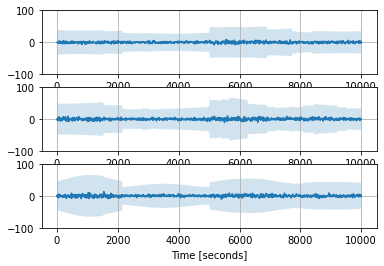

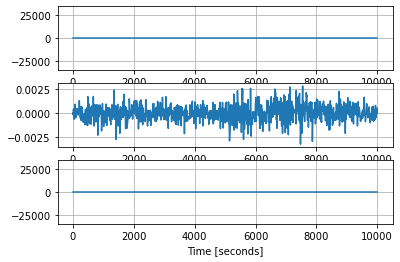

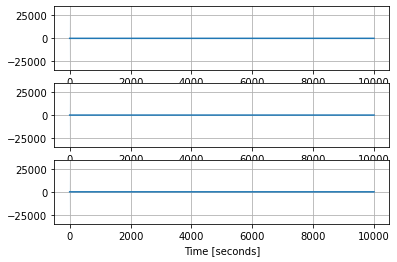

In [13]:
##############################################################################
##############################################################################
###                                                                        ###
###                               PLOTTING                                 ###
###                                                                        ###
##############################################################################
##############################################################################

plt.close('all')

# Position ECI

timeAxis = np.linspace( 0, duration, samples)
stdev = np.sqrt(P_history)

fig123, (ax1, ax2, ax3) = plt.subplots(3)
ax1.plot( timeAxis, xt_history[0,:] - x_history[0,:])
ax1.fill_between( timeAxis, stdev[0,:], -stdev[0,:], alpha=0.2 )
ax1.set_ylim(-20*1000*R, 20*1000*R)
ax1.grid()
ax2.plot( timeAxis, xt_history[1,:] - x_history[1,:])
ax2.fill_between( timeAxis, stdev[1,:], -stdev[1,:], alpha=0.2 )
ax2.set_ylim(-20*1000*R, 20*1000*R)
ax2.grid()
ax3.plot( timeAxis, xt_history[2,:] - x_history[2,:])
ax3.fill_between( timeAxis, stdev[2,:], -stdev[2,:], alpha=0.2 )
ax3.set_ylim(-20*1000*R, 20*1000*R)
ax3.set_xlabel('Time [seconds]')
ax3.grid()

# Velocity ECI

fig456, (ax4, ax5, ax6) = plt.subplots(3)
ax4.plot( timeAxis, xt_history[3,:] - x_history[3,:])
ax4.fill_between( timeAxis, stdev[3,:], -stdev[3,:], alpha=0.2 )
#ax4.set_ylim(-20*1000*Rdot, 20*1000*Rdot)
ax4.grid()
ax5.plot( timeAxis, xt_history[4,:] - x_history[4,:])
#ax5.set_ylim(-20*1000*Rdot, 20*1000*Rdot)
ax5.grid()
ax6.plot( timeAxis, xt_history[5,:] - x_history[5,:])
ax6.fill_between( timeAxis, stdev[5,:], -stdev[5,:], alpha=0.2 )
#ax6.set_ylim(-20*1000*Rdot, 20*1000*Rdot)
ax6.set_xlabel('Time [seconds]')
ax6.grid()

# rel position RTN error
fig789, (ax7, ax8, ax9) = plt.subplots(3)
ax7.plot( timeAxis, xt_history[6,:] - x_history[6,:])
ax7.fill_between( timeAxis, stdev[6,:], -stdev[6,:], alpha=0.2 )
#ax7.set_ylim(-200*1000*R, 200*1000*R)
ax7.grid()
ax8.plot( timeAxis, xt_history[7,:] - x_history[7,:])
ax8.fill_between( timeAxis, stdev[7,:], -stdev[7,:], alpha=0.2 )
#ax8.set_ylim(-200*1000*R, 200*1000*R)
ax8.grid()
ax9.plot( timeAxis, xt_history[8,:] - x_history[8,:])
ax9.fill_between( timeAxis, stdev[8,:], -stdev[8,:], alpha=0.2 )
#ax9.set_ylim(-200*1000*R, 200*1000*R)
ax9.set_xlabel('Time [seconds]')
ax9.grid()

# rel position RTN
#fig789b, (ax7b, ax8b, ax9b) = plt.subplots(3)
#ax7b.plot( timeAxis, xt_history[6,:])
#ax7b.set_ylim(-1000000, 1000000)
#ax7b.grid()
#ax8b.plot( timeAxis, xt_history[7,:])
#ax8b.set_ylim(-1000000, 1000000)
#ax8b.grid()
#ax9b.plot( timeAxis, xt_history[8,:])
#ax9b.set_ylim(-1000000, 1000000)
#ax9b.set_xlabel('Time [seconds]')
#ax9b.grid()

# rel position RTN error between STM and prop
#fig789, (ax7, ax8, ax9) = plt.subplots(3)
#ax7.plot( timeAxis, xt_history[6,:] - xp_history[6,:])
#ax7.fill_between( timeAxis, stdev[6,:], -stdev[6,:], alpha=0.2 )
#ax7.set_ylim(-200*1000*R, 200*1000*R)
#ax7.grid()
#ax8.plot( timeAxis, xt_history[7,:] - xp_history[7,:])
#ax8.fill_between( timeAxis, stdev[7,:], -stdev[7,:], alpha=0.2 )
#ax8.set_ylim(-200*1000*R, 200*1000*R)
#ax8.grid()
#ax9.plot( timeAxis, xt_history[8,:] - xp_history[8,:])
#ax9.fill_between( timeAxis, stdev[8,:], -stdev[8,:], alpha=0.2 )
#ax9.set_ylim(-200*1000*R, 200*1000*R)
#ax9.set_xlabel('Time [seconds]')
#ax9.grid()


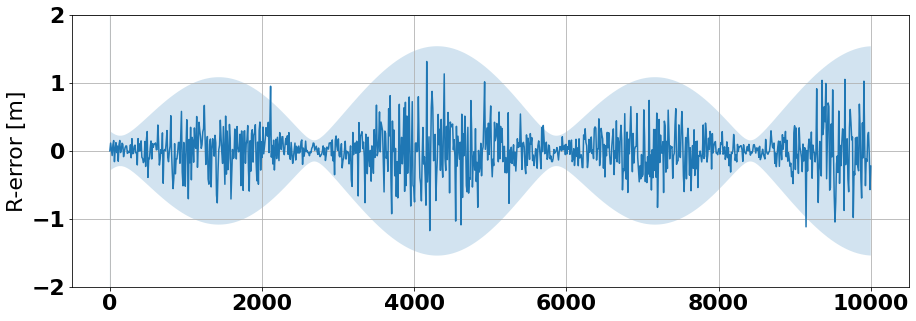

In [14]:
plt.rcParams['figure.figsize'] = [15, 5]
font = {'weight' : 'bold',
        'size'   : 22}

matplotlib.rc('font', **font)
figb, axb = plt.subplots()
#axb.plot( timeAxis[0:200], xt_history[6,0:200]-x_history[6,0:200])
axb.plot(timeAxis[:], xt_history[6,:] - x_history[6,:])
axb.fill_between( timeAxis[:], 3*stdev[6,:], -3*stdev[6,:], alpha=0.2 )
axb.set_ylim(-2, 2)
axb.set_ylabel('R-error [m]')
axb.grid()

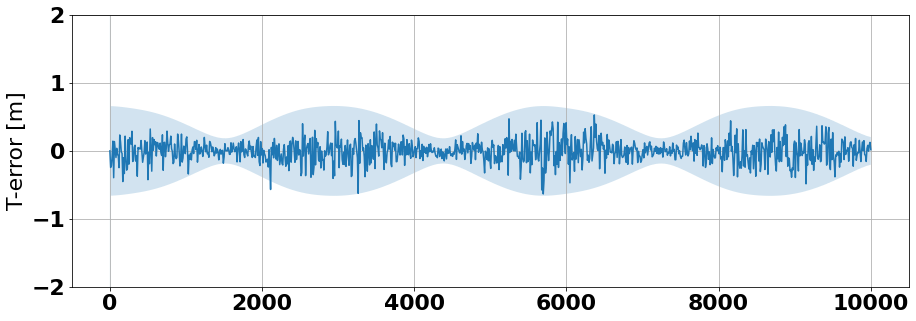

In [15]:
figb, axb = plt.subplots()
#axb.plot( timeAxis[0:200], xt_history[6,0:200]-x_history[6,0:200])
axb.plot(timeAxis[:], xt_history[7,:] - x_history[7,:])
axb.fill_between( timeAxis[:], 3*stdev[7,:], -3*stdev[7,:], alpha=0.2 )
axb.set_ylim(-2, 2)
axb.set_ylabel('T-error [m]')
axb.grid()

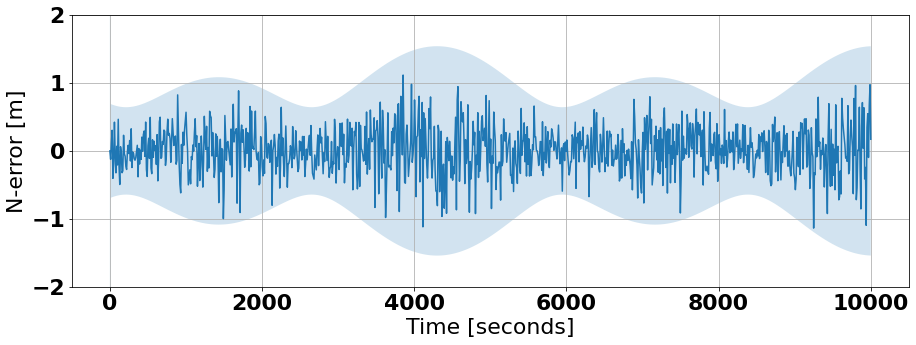

In [16]:
plt.rcParams['figure.figsize'] = [15, 5]
figb, axb = plt.subplots()
#axb.plot( timeAxis[0:200], xt_history[6,0:200]-x_history[6,0:200])
axb.plot(timeAxis[:], xt_history[8,:] - x_history[8,:])
axb.fill_between( timeAxis[:], 3*stdev[8,:], -3*stdev[8,:], alpha=0.2 )
axb.set_ylim(-2, 2)
axb.set_ylabel('N-error [m]')
axb.set_xlabel('Time [seconds]')
axb.grid()

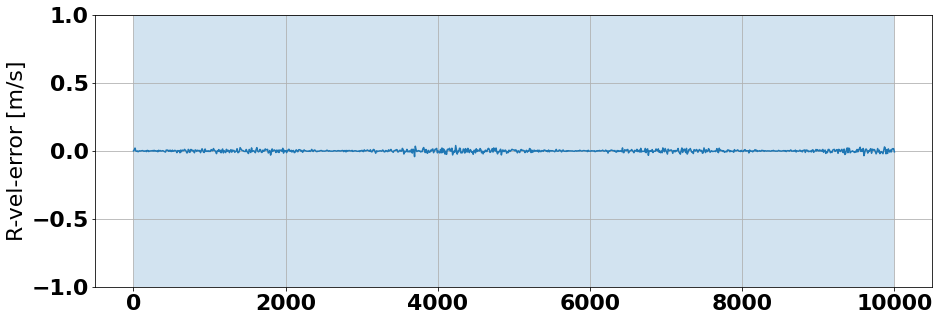

In [9]:
figb, axb = plt.subplots()
#axb.plot( timeAxis[0:200], xt_history[6,0:200]-x_history[6,0:200])
axb.plot(timeAxis[:], xt_history[9,:] - x_history[9,:])
axb.fill_between( timeAxis[:], 3*stdev[9,:], -3*stdev[9,:], alpha=0.2 )
axb.set_ylim(-1, 1)
axb.set_ylabel('R-vel-error [m/s]')
axb.grid()

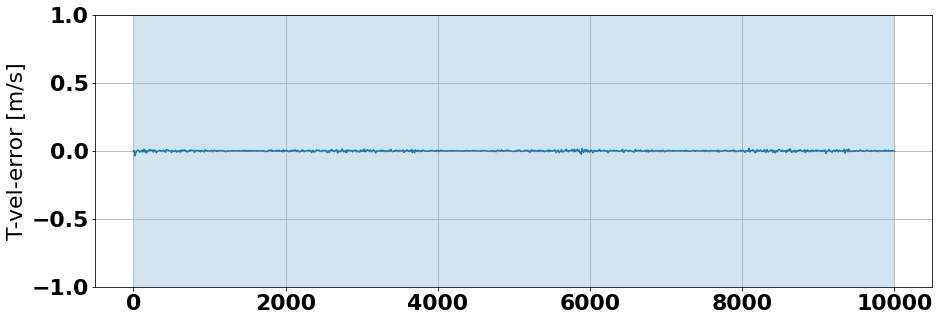

In [10]:
figb, axb = plt.subplots()
#axb.plot( timeAxis[0:200], xt_history[6,0:200]-x_history[6,0:200])
axb.plot(timeAxis[:], xt_history[10,:] - x_history[10,:])
axb.fill_between( timeAxis[:], 3*stdev[10,:], -3*stdev[10,:], alpha=0.2 )
axb.set_ylim(-1, 1)
axb.set_ylabel('T-vel-error [m/s]')
axb.grid()

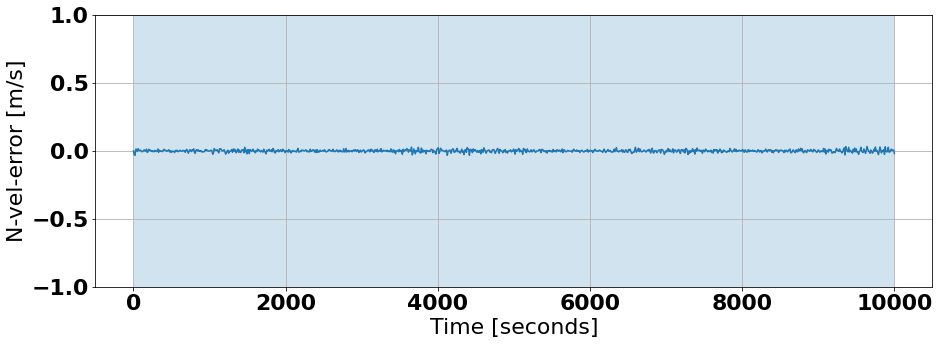

In [11]:
figb, axb = plt.subplots()
#axb.plot( timeAxis[0:200], xt_history[6,0:200]-x_history[6,0:200])
axb.plot(timeAxis[:], xt_history[11,:] - x_history[11,:])
axb.fill_between( timeAxis[:], 3*stdev[11,:], -3*stdev[11,:], alpha=0.2 )
axb.set_ylim(-1, 1)
axb.set_ylabel('N-vel-error [m/s]')
axb.set_xlabel('Time [seconds]')
axb.grid()

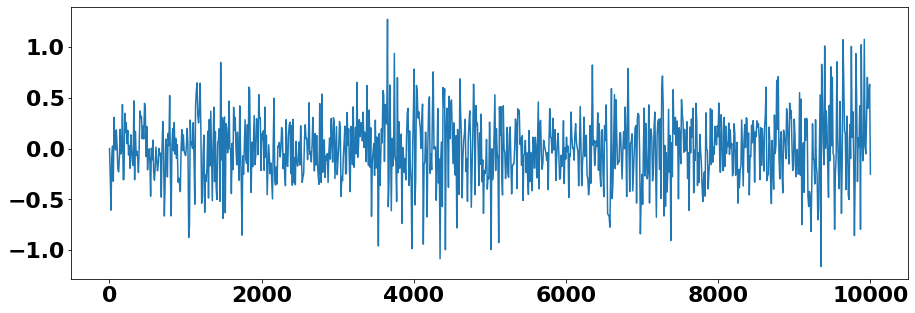

In [12]:
figb, axb = plt.subplots()
#axb.plot( timeAxis[0:200], xt_history[6,0:200]-x_history[6,0:200])
axb.plot(timeAxis, xt_history[8,:] - x_history[8,:])
#axb.fill_between( timeAxis, stdev[8,:], -stdev[8,:], alpha=0.2 )

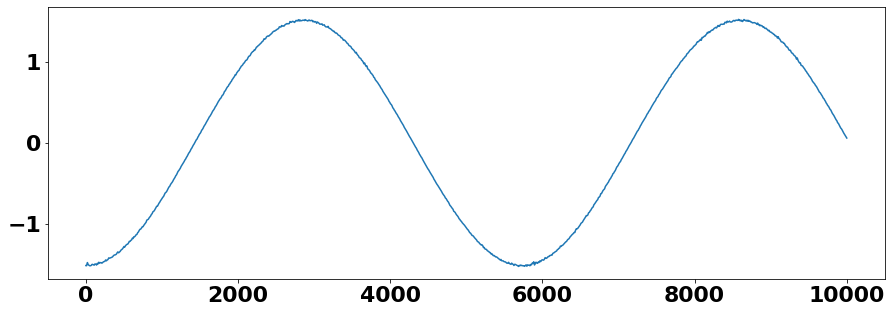

In [13]:
figb, axb = plt.subplots()
axb.plot( timeAxis, x_history[10,:])

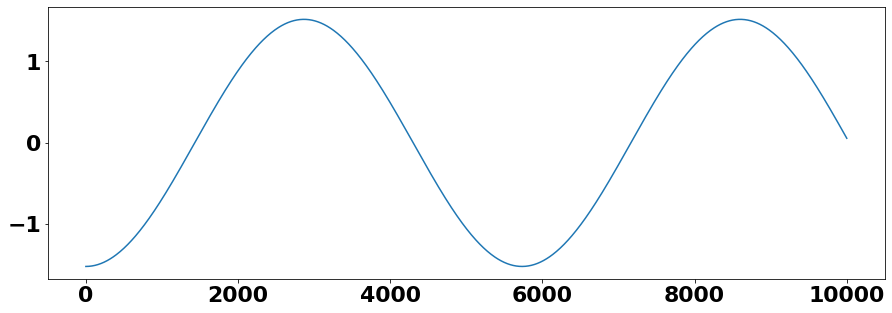

In [14]:
figb, axb = plt.subplots()
axb.plot( timeAxis, xt_history[10,:])

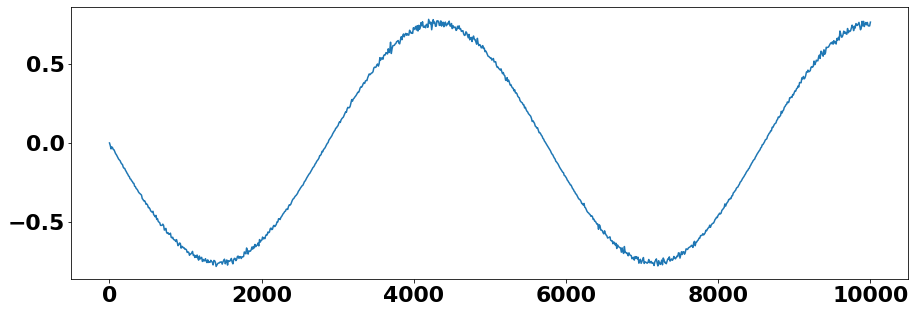

In [15]:
figb, axb = plt.subplots()
axb.plot( timeAxis, x_history[9,:])

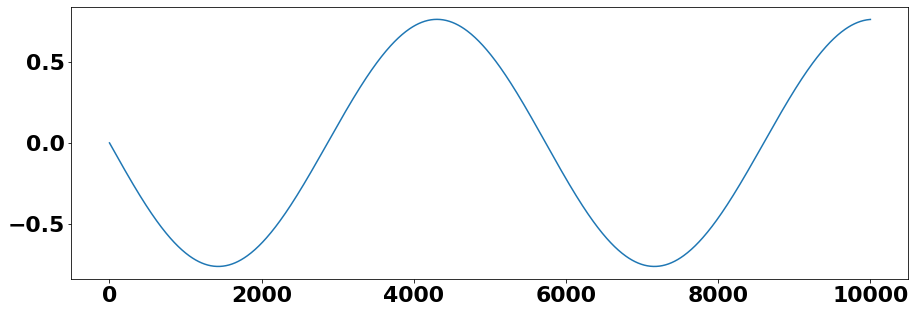

In [16]:
figb, axb = plt.subplots()
axb.plot( timeAxis, xt_history[9,:])

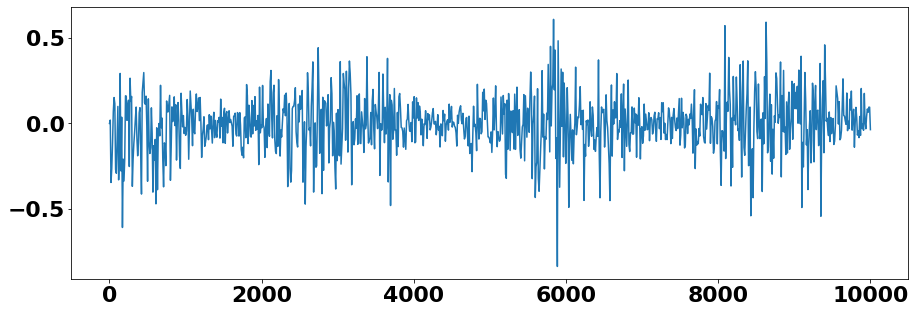

In [17]:
figb, axb = plt.subplots()
axb.plot( timeAxis, xt_history[7,:]-x_history[7,:])

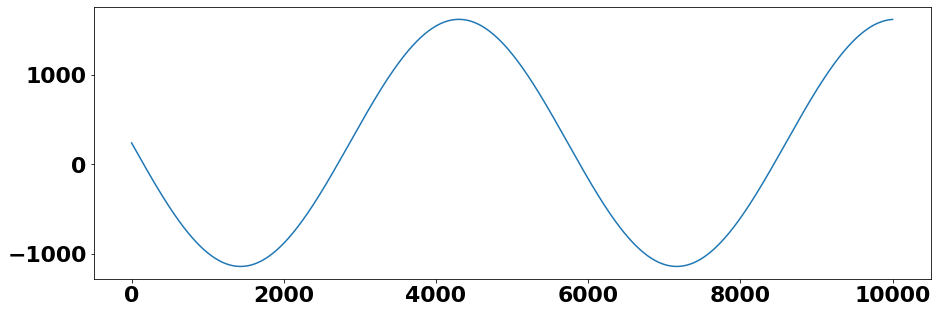

In [18]:
figb, axb = plt.subplots()
axb.plot( timeAxis, xt_history[7,:])

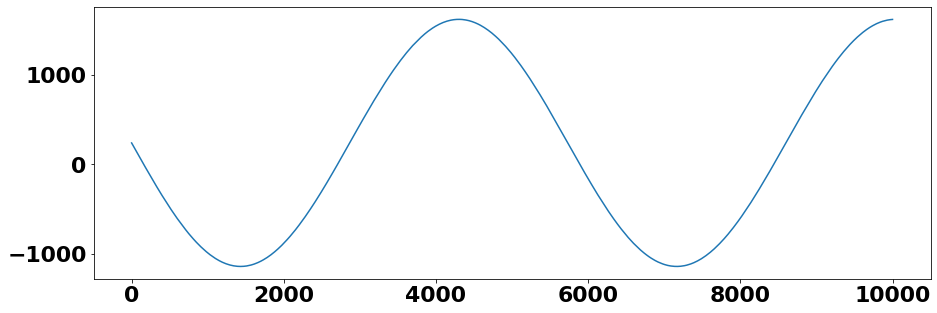

In [19]:
figb, axb = plt.subplots()
axb.plot( timeAxis, x_history[7,:])

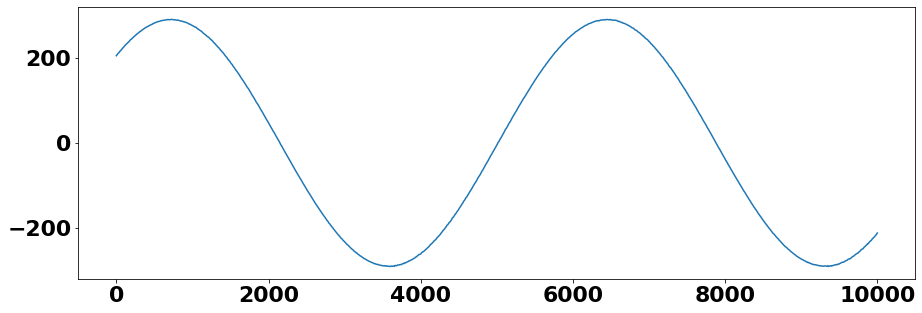

In [20]:
figb, axb = plt.subplots()
axb.plot( timeAxis, x_history[8,:])

(-318.9697888012705, 318.5595617388881, -761.0025952430733, 760.9881959487947)

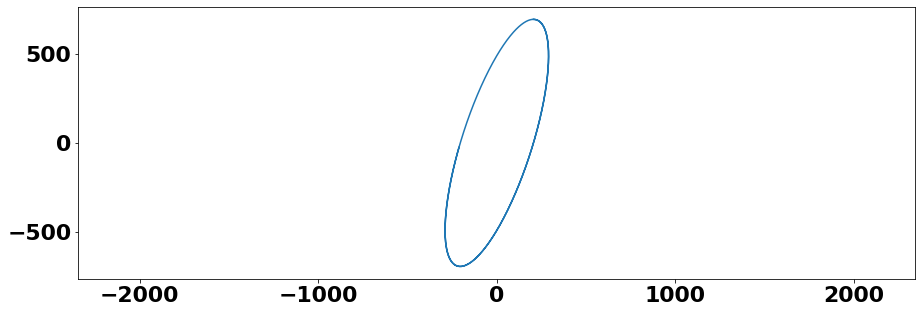

In [21]:
figb, axb = plt.subplots()
axb.plot( xt_history[8,:],xt_history[6,:])
axb.axis('equal')

(-318.9918845473413, 318.53887865950753, -765.6774218669434, 761.2790196183267)

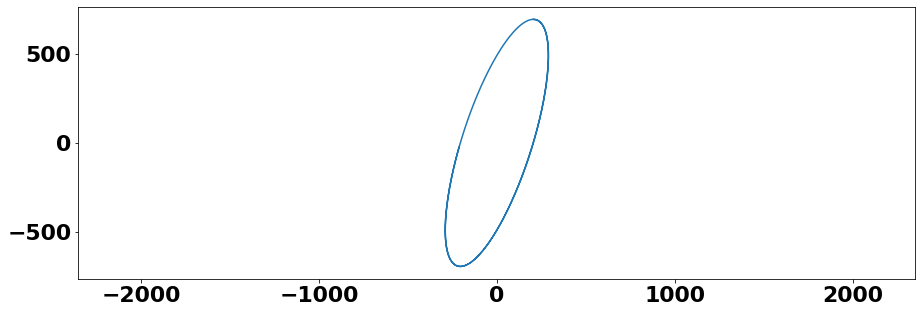

In [22]:
figb, axb = plt.subplots()
axb.plot( xp_history[8,:],xp_history[6,:])
axb.axis('equal')

(-319.5824862701882, 319.2793930483961, -761.1494830265018, 760.9951906051484)

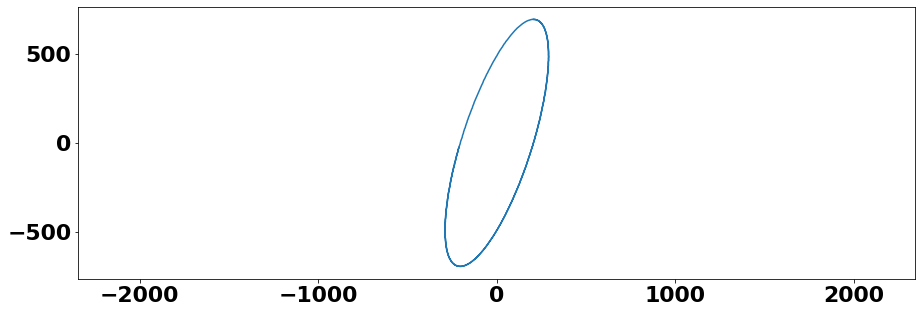

In [23]:
figb, axb = plt.subplots()
axb.plot( x_history[8,:],x_history[6,:])
axb.axis('equal')